In [4]:
import tensorflow as tf
import sklearn.cluster as cluster
import sklearn.preprocessing as preprocessing
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from importlib import reload 
import Evaluate
import AutoEncoder
from time import time

Using TensorFlow backend.


## Utility functions

In [12]:
def plot66(model,data):
    """
    plot a 6 x 6 image sample regarding to the prediction of a model over a data
    """
    fig = plt.figure(figsize=(18, 18), dpi= 80, facecolor='w', edgecolor='k')
    ps = fig.subplots(6,6)
    preds = model.predict_raw(data[:36]).reshape((6,6, 28,28))
    for p in range(len(ps)):
        for q in range(len(ps[p])):
            ps[p][q].imshow(preds[p][q], cmap='Greys')
            ps[p][q].get_xaxis().set_visible(False)
            ps[p][q].get_yaxis().set_visible(False)
    plt.show()
    #print(model.encode(data[:36], output_argmax=True).reshape(6,6))
    #print(model.encode(data[:36]).max(axis=-1).reshape(6,6))
    
def plot66_with_dec(model, ae, decoder, data):
    fig = plt.figure(figsize=(18, 18), dpi= 80, facecolor='w', edgecolor='k')
    ps = fig.subplots(6,6)
    tp = model.predict_raw(ae.encode(data[:36]))
    preds = decoder.predict(tp).reshape((6,6, 28,28))
    for p in range(len(ps)):
        for q in range(len(ps[p])):
            ps[p][q].imshow(preds[p][q], cmap='Greys')
            ps[p][q].get_xaxis().set_visible(False)
            ps[p][q].get_yaxis().set_visible(False)
    plt.show()
    #print(model.encode(ae.encode(data[:36]), output_argmax=True).reshape(6,6))
    #print(model.encode(ae.encode(data[:36])).max(axis=-1).reshape(6,6))
    
def plot_raw_66(data):
    fig = plt.figure(figsize=(18, 18), dpi= 80, facecolor='w', edgecolor='k')
    ps = fig.subplots(6,6)
    data = data[:36].reshape((6,6, 28,28))
    for p in range(len(ps)):
        for q in range(len(ps[p])):
            ps[p][q].imshow(data[p][q], cmap='Greys')
            ps[p][q].get_xaxis().set_visible(False)
            ps[p][q].get_yaxis().set_visible(False)
    plt.show()
    
def plot_activate(cols, model, dataX, data, shape, num, figsize, rows=1):
    """
    plot the activation pattern of encoder regarding certain data
    """
    fig = plt.figure(figsize=figsize, dpi=80, facecolor='w', edgecolor='k')
    ps = fig.subplots(2*rows, cols)
    preds = model.encode(dataX[:cols * rows]).reshape((cols * rows, num))
    for row in range(rows):
        for col in range(cols):
            ps[2*row+0][col].imshow(data[row * cols + col],cmap='Greys')
            ps[2*row+1][col].imshow(preds[row * cols + col].reshape(shape))
            ps[2*row+0][col].get_xaxis().set_visible(False)
            ps[2*row+0][col].get_yaxis().set_visible(False)
            ps[2*row+1][col].get_xaxis().set_visible(False)
            ps[2*row+1][col].get_yaxis().set_visible(False)
    plt.show()

def plot_hist(model, start=0):
    fig = plt.figure(figsize=(18,12), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(model.history.history['loss'][start:])
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')

## MNIST

In [95]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
import Preprocessing
%matplotlib inline
x_train_noised = Preprocessing.MnistNoisifier().noisify(10, x_train)

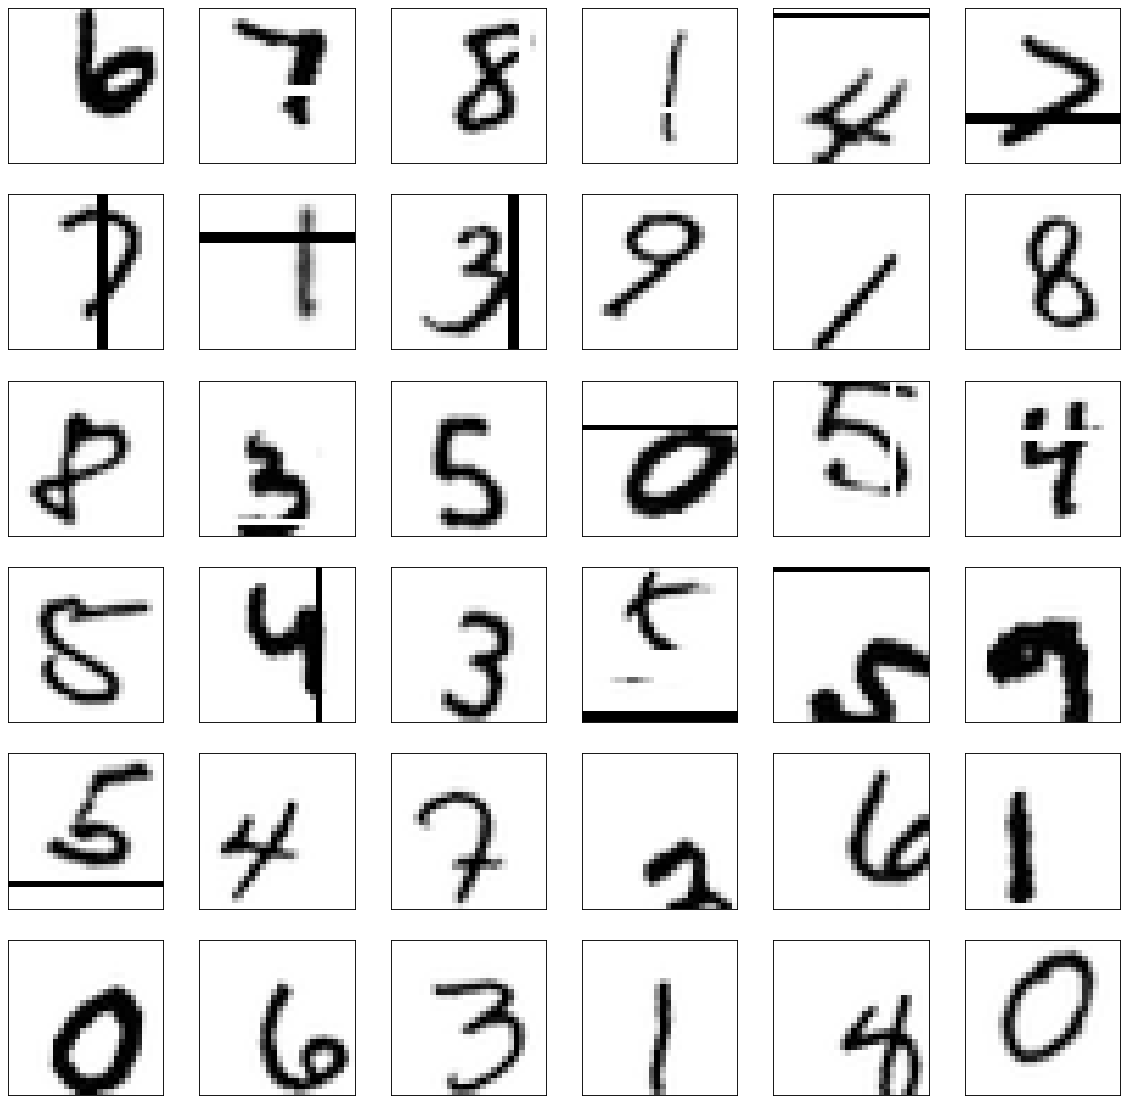

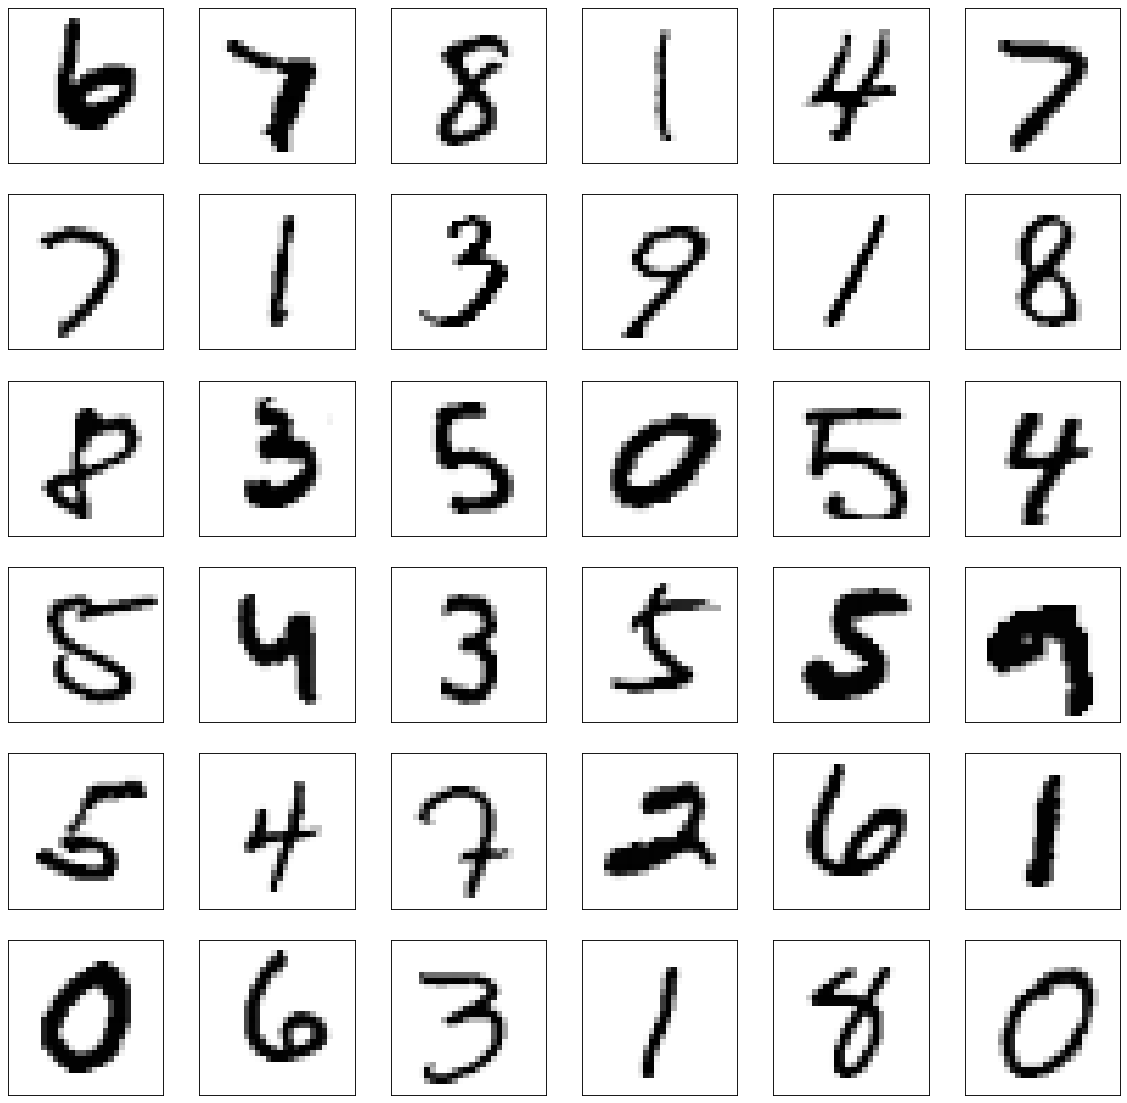

In [73]:
plot_raw_66(x_train_noised[0])
plot_raw_66(x_train_noised[1])

In [96]:
y_train_col = np.expand_dims(y_train, axis=1)
(n_data, n_fx, n_fy) = x_train.shape
x_train_1d = x_train.reshape((n_data, n_fx * n_fy))
x_test_1d = x_test.reshape((x_test.shape[0], n_fx * n_fy))

### Run K-means as baseline metrics 

In [75]:
t0 = time()
km = cluster.KMeans(n_clusters=10).fit(x_train_1d)
print(time() - t0)
t1 = time()
kmeans_score_train = Evaluate.evaluate_(km.predict(x_train_1d), y_train)
print(time() - t1)
t2 = time()
kmeans_score_test = Evaluate.evaluate_(km.predict(x_test_1d), y_test)
print(time() - t2)
print(kmeans_score_train, kmeans_score_test)

94.82437515258789
0.510735034942627
0.08603882789611816
(0.49650189456649857, 0.4851178083704403, 0.490743839438489, 0.49077684434360913, 0.5128833333333334) (0.5049186204410189, 0.49258075712557425, 0.4986733865446115, 0.49871153620468567, 0.5168)


/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


# Build auto-encoder

In [98]:
reload(AutoEncoder)
ae = AutoEncoder.Standard([480, 240, 144], input_shape=(28, 28))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 28, 28)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 480)               376800    
_________________________________________________________________
dense_38 (Dense)             (None, 240)               115440    
_________________________________________________________________
dense_39 (Dense)             (None, 144)               34704     
_________________________________________________________________
dense_40 (Dense)             (None, 240)               34800     
__________

In [99]:
#ae.fit_(x_train_noised[0], x_train_noised[1], epochs=500, batch_size=5000)
#ae.load_weights('../models', 'ae')
ae.load_weights('../models/noise', 'ae_tt')

### Test KMeans over data embedding

In [86]:
t0 = time()
predicted = ae.encode(x_train)
print(time() - t0)

t0 = time()
tpredicted = ae.encode(x_test)
print(time() - t0)

t0 = time()
km2 = cluster.KMeans(n_clusters=10).fit(predicted)
print(time() - t0)
t1 = time()
kmeans_ae_score_train = Evaluate.evaluate_(km2.predict(predicted), y_train)
print(time() - t1)
t2 = time()
kmeans_ae_score_test = Evaluate.evaluate_(km2.predict(tpredicted), y_test)
print(time() - t2)
print(kmeans_ae_score_train, kmeans_ae_score_test)

1.4226481914520264
0.21504855155944824
14.358770847320557
0.16442108154296875
0.04430270195007324
(0.48081242668318835, 0.46864187170064975, 0.47464914522225193, 0.4746881456048179, 0.54665) (0.49880682524520725, 0.4866241216942068, 0.4926401671956995, 0.4926778188938738, 0.5589)


/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


### The decoder of encoder ae

In [100]:
import keras
aed_in = keras.layers.Input(shape=(144,))
aed_h = aed_in
aed_h = ae.autoencoder.layers[-4](aed_h)
aed_h = ae.autoencoder.layers[-3](aed_h)
aed_h = ae.autoencoder.layers[-2](aed_h)
aed_out = ae.autoencoder.layers[-1](aed_h)
aed = keras.Model(aed_in, aed_out)
aed.summary()
#ae.save_weights('../models', 'ae')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 144)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 240)               34800     
_________________________________________________________________
dense_41 (Dense)             (None, 480)               115680    
_________________________________________________________________
dense_42 (Dense)             (None, 784)               377104    
_________________________________________________________________
reshape_9 (Reshape)          (None, 28, 28)            0         
Total params: 527,584
Trainable params: 527,584
Non-trainable params: 0
_________________________________________________________________


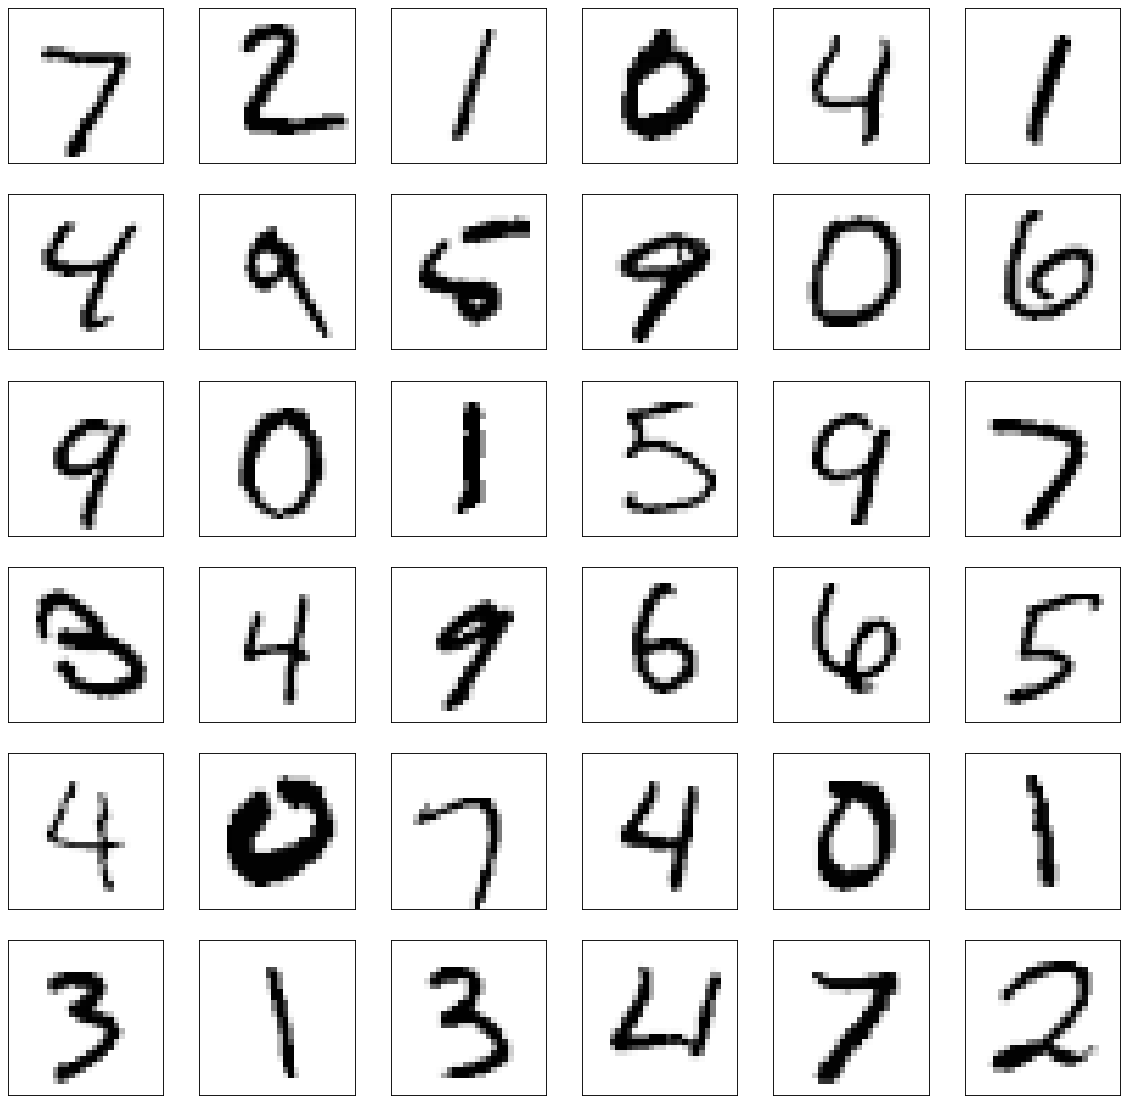

In [183]:
plot_raw_66(x_test)

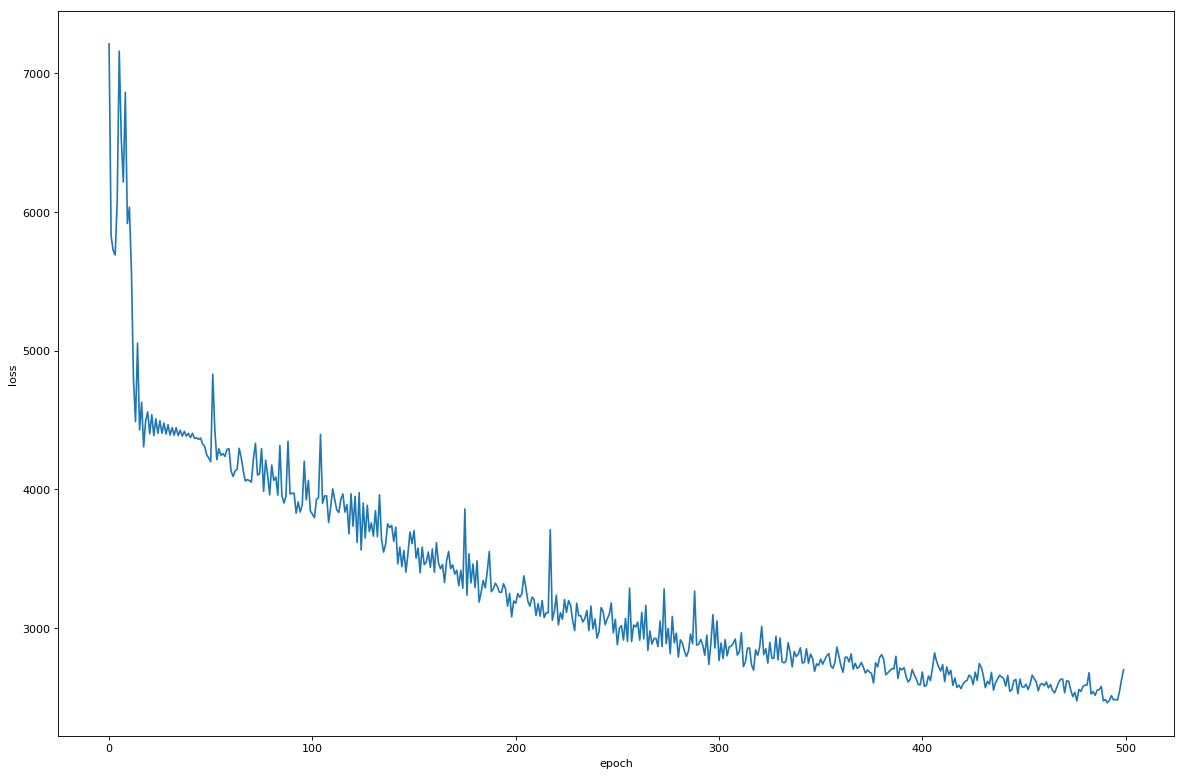

In [571]:
plot_hist(ae)

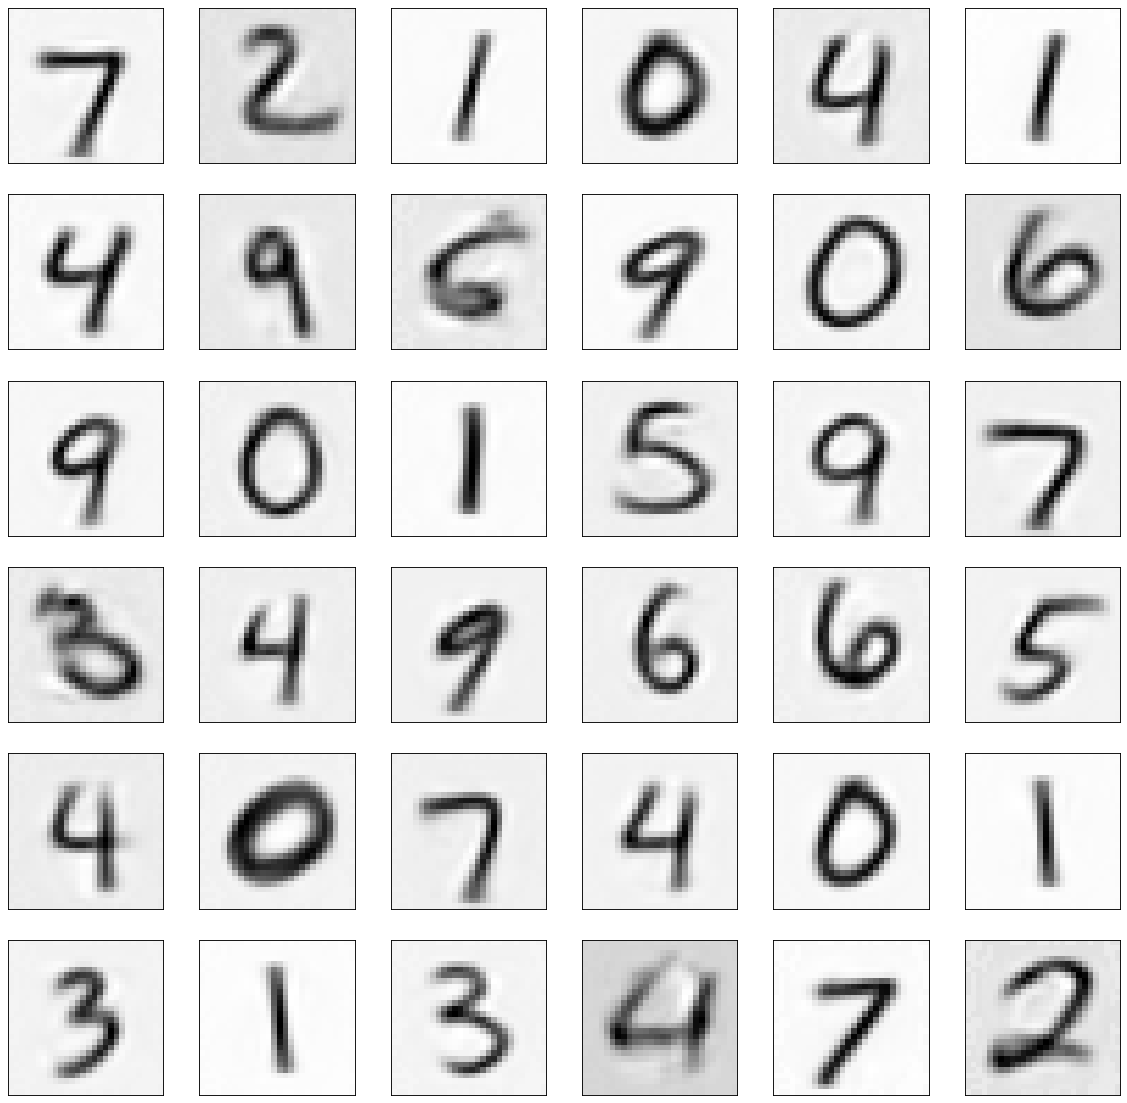

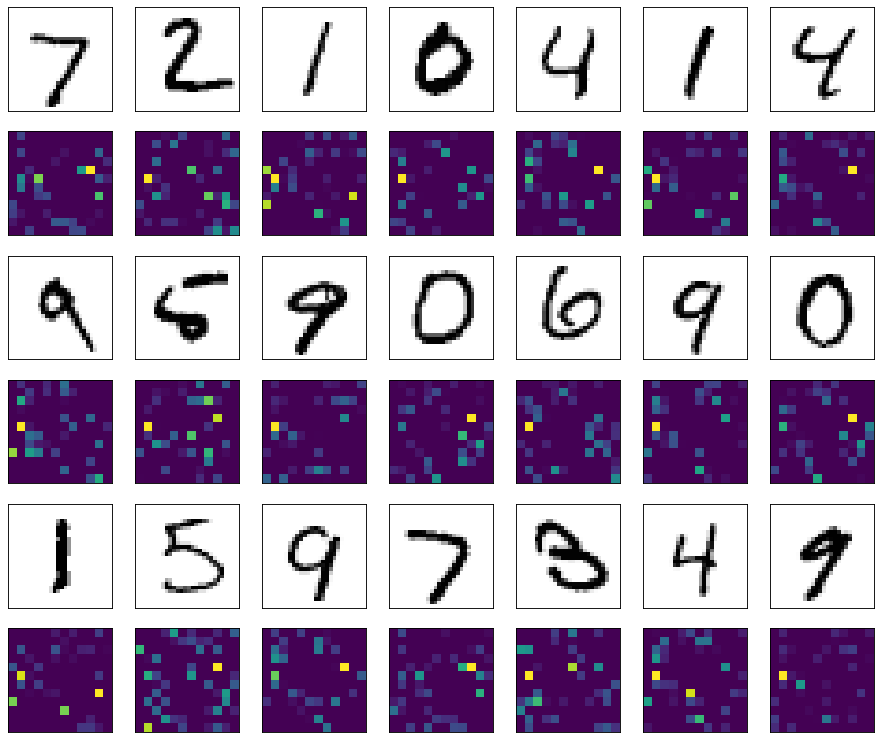

In [48]:
plot66(ae, x_test)
plot_activate(7, ae, x_test, x_test, (12,12), 144, (14,12), rows=3)

### First version of CAE

In [6]:
#reload(AutoEncoder)
cls_1 = AutoEncoder.Clustering([480, 144, 64, 10], input_shape=(28, 28), 
                               loss_balance_t=0, loss_confidence_t=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 480)               376800    
_________________________________________________________________
dense_2 (Dense)              (None, 144)               69264     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                9280      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
__________

In [7]:
cls_1.load_weights('../models', 'cls_1')
#cls_1.fit_(x_train, x_train, epochs=50, batch_size=30000)

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [84]:
#cls_1.load_weights('../models/noise', 'cls_1')
cls_1.load_weights('../models', 'cls_1')

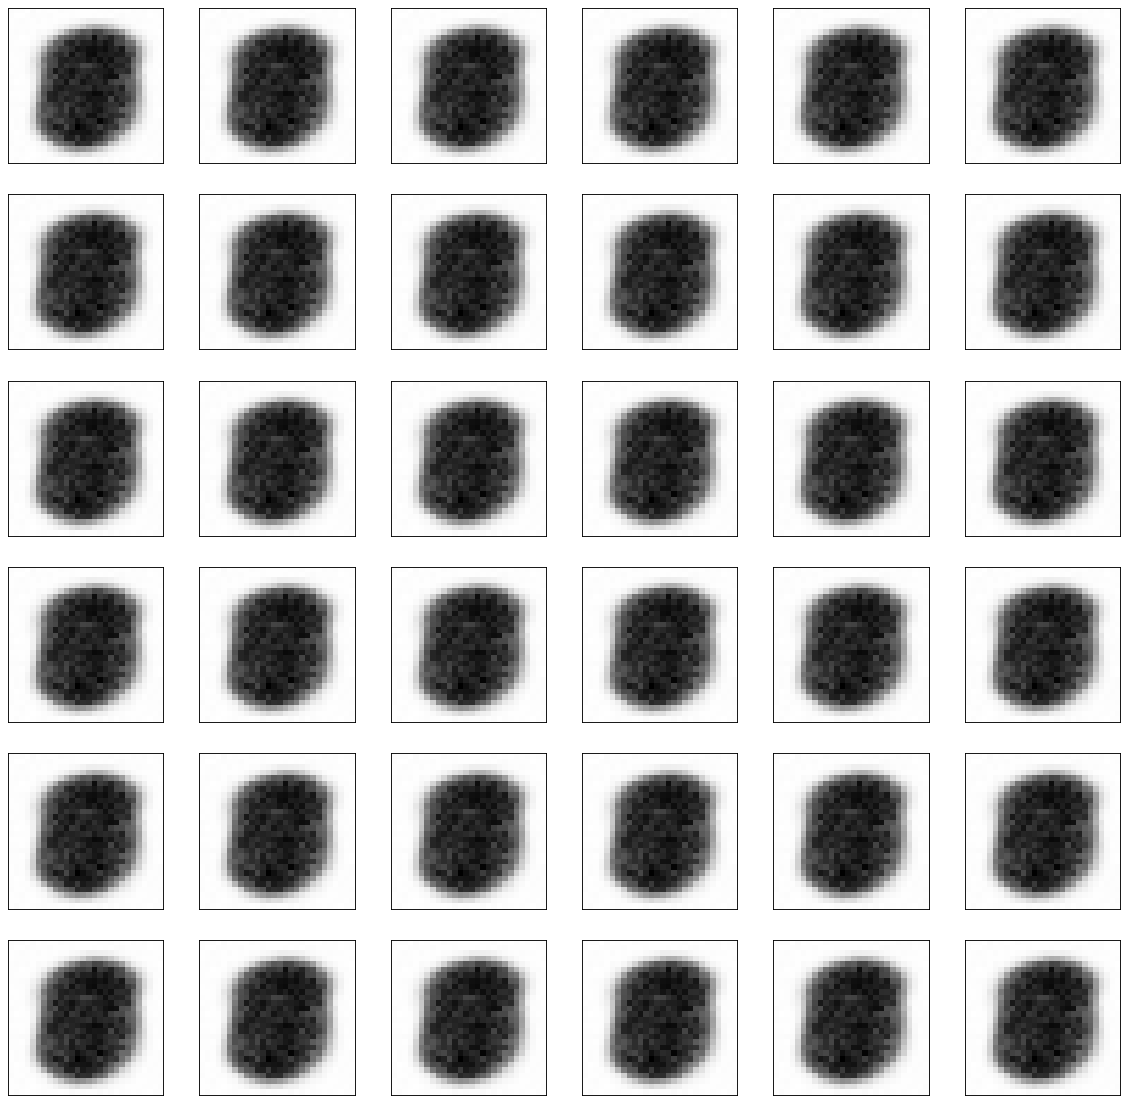

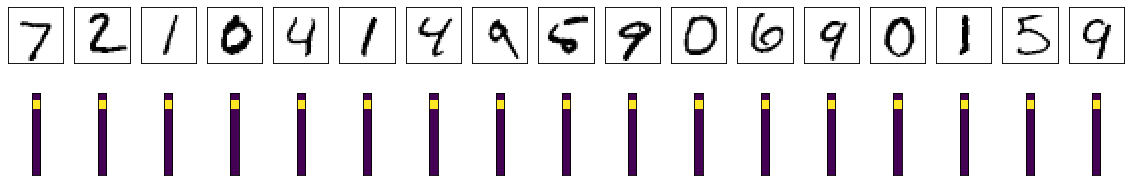

In [51]:
plot66(cls_1, x_test)
plot_activate(17, cls_1, x_test, x_test, (10,1), 10, (18, 3))
#print(kmeans_score_test)
#print(kmeans_score_test_on_ae)
#kmeans_score_test_on_cls1 = Evaluate.evaluate_(cls_1.encode(x_test, output_argmax=True), y_test)
#print(kmeans_score_test_on_cls1)

### CAE with regularisation

In [79]:
reload(AutoEncoder)
cls_2 = AutoEncoder.Clustering([480, 144, 64, 10], input_shape=(n_fx, n_fy), 
                               loss_balance_t=0.7, loss_confidence_t=0.5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 28)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 480)               376800    
_________________________________________________________________
dense_55 (Dense)             (None, 144)               69264     
_________________________________________________________________
dense_56 (Dense)             (None, 64)                9280      
_________________________________________________________________
dense_57 (Dense)             (None, 10)                650       
__________

In [81]:
#cls_2.fit_(x_train_noised[0], x_train_noised[1], epochs=500, batch_size=30000)
cls_2.load_weights('../models', 'cls_2')
#cls_2.save_weights('../models/noise', 'cls_2')

Epoch 1/500
600000/600000 [==============================] - 4s 6us/step - loss: 6957.1533
Epoch 2/500
600000/600000 [==============================] - 3s 5us/step - loss: 5045.7136
Epoch 3/500
600000/600000 [==============================] - 3s 5us/step - loss: 4854.4446
Epoch 4/500
600000/600000 [==============================] - 3s 5us/step - loss: 4699.9081
Epoch 5/500
600000/600000 [==============================] - 3s 5us/step - loss: 4649.8670
Epoch 6/500
600000/600000 [==============================] - 3s 5us/step - loss: 4661.1292
Epoch 7/500
600000/600000 [==============================] - 3s 5us/step - loss: 4607.7221
Epoch 8/500
600000/600000 [==============================] - 3s 5us/step - loss: 4590.9794
Epoch 9/500
600000/600000 [==============================] - 3s 5us/step - loss: 4585.3772
Epoch 10/500
600000/600000 [==============================] - 3s 5us/step - loss: 4560.5481
Epoch 11/500
600000/600000 [==============================] - 3s 5us/step - loss: 4538.90

KeyboardInterrupt: 

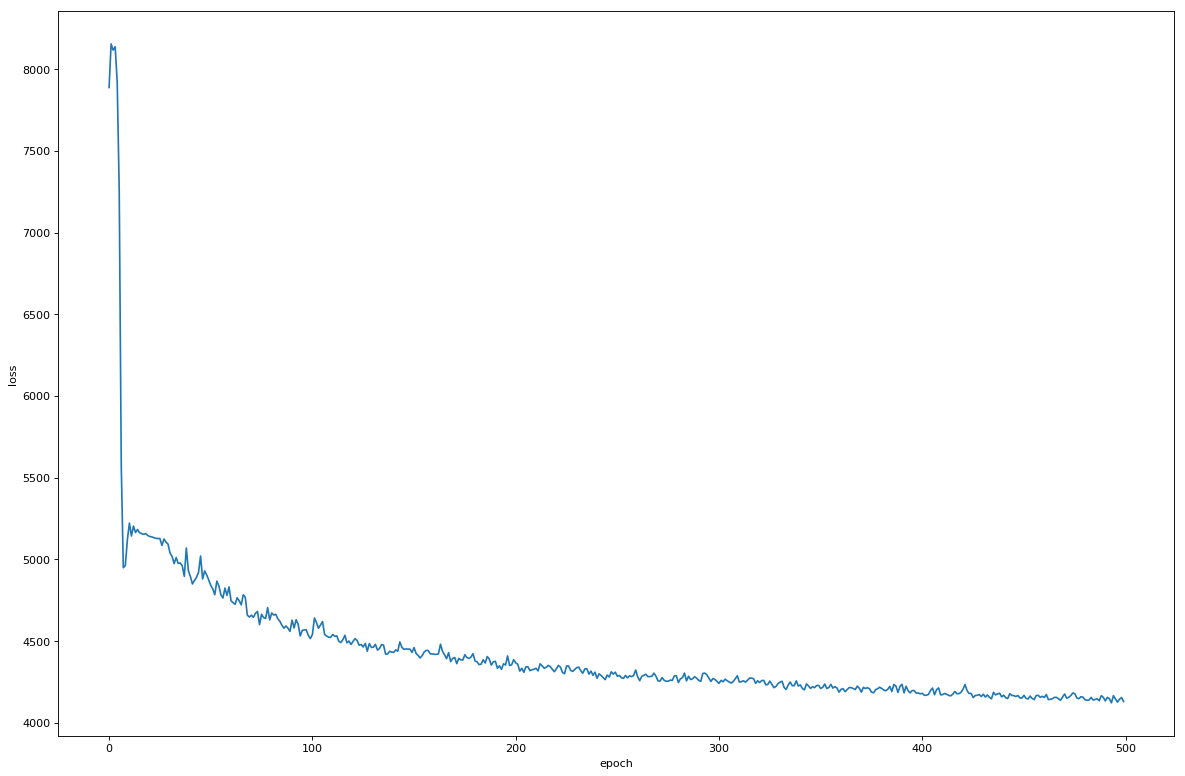

In [584]:
plot_hist(cls_2)

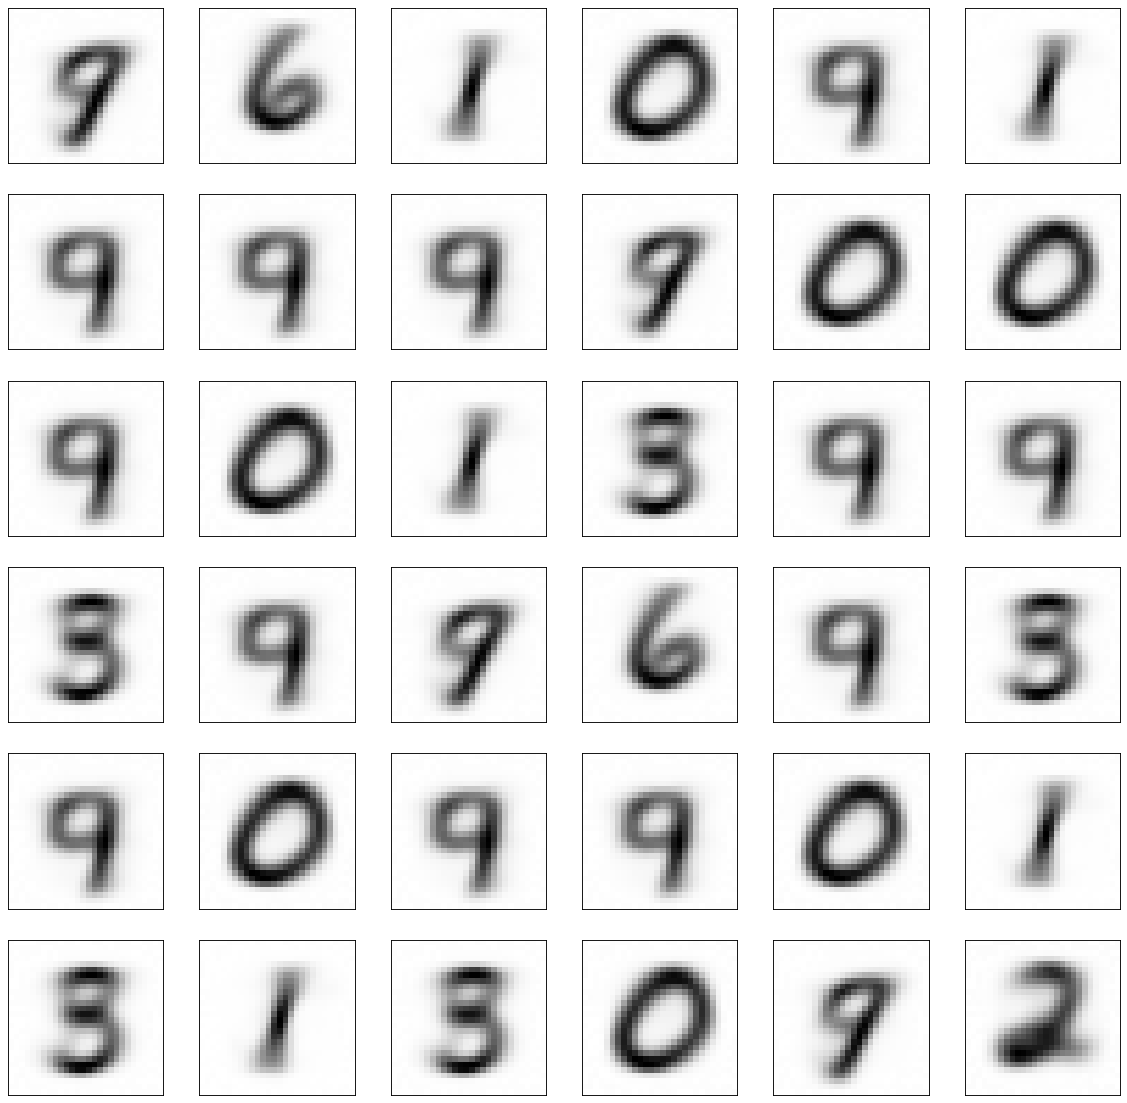

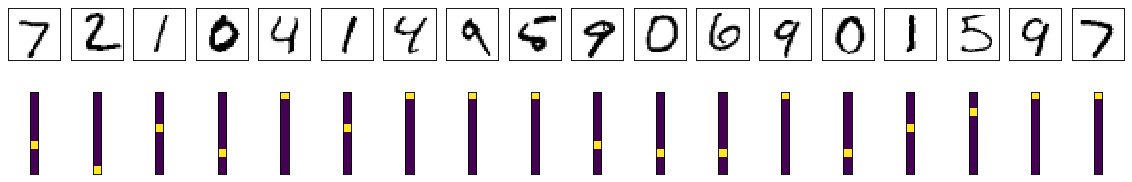

1.5906388759613037
0.25247669219970703
(0.5685706009336164, 0.47134363122074835, 0.5154119894949818, 0.5176795646434325, 0.40376215048502634, 0.5657666666666666) (0.5835103367765754, 0.4825844033434207, 0.5282701004346891, 0.5306533592827263, 0.41193029081381316, 0.5689)


In [88]:
reload(Evaluate)
plot66(cls_2, x_test)
plot_activate(18, cls_2, x_test, x_test, (10,1), 10, (18, 3))
#print(kmeans_score_test)
#print(kmeans_score_test_on_ae)
#print(kmeans_score_test_on_cls1)
t0 = time()
e1 = Evaluate.evaluate_(cls_2.encode(x_train, output_argmax=True), y_train)
print(time()-t0)
t0 = time()
e2 = Evaluate.evaluate_(cls_2.encode(x_test, output_argmax=True), y_test)
print(time()-t0)
print(e1,e2)


### CAE stacked with AE

In [105]:
reload(AutoEncoder)
cls_ae = AutoEncoder.Clustering([64, 10], input_shape=(144,), 
                               loss_balance_t=1, loss_confidence_t=0.3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 144)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 144)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 64)                9280      
_________________________________________________________________
dense_79 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_80 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_81 (Dense)             (None, 144)               9360      
_________________________________________________________________
reshape_12 (Reshape)         (None, 144)               0         
Total para

In [106]:
X_for_cls2 = ae.encode(x_train)
#cls_ae.fit_(X_for_cls2, X_for_cls2, epochs=1000, batch_size=30000)
cls_ae.load_weights('../models/noise', 'cls_ae') # use the denoising ae
#cls_ae.load_weights('../models', 'cls_ae')

Epoch 1/1000
60000/60000 [==============================] - 1s 12us/step - loss: 6396.2954
Epoch 2/1000
60000/60000 [==============================] - 0s 1us/step - loss: 6235.2241
Epoch 3/1000
60000/60000 [==============================] - 0s 1us/step - loss: 6132.8931
Epoch 4/1000
60000/60000 [==============================] - 0s 1us/step - loss: 6060.6416
Epoch 5/1000
60000/60000 [==============================] - 0s 1us/step - loss: 6061.1392
Epoch 6/1000
60000/60000 [==============================] - 0s 1us/step - loss: 6070.0271
Epoch 7/1000
60000/60000 [==============================] - 0s 1us/step - loss: 6067.0662
Epoch 8/1000
60000/60000 [==============================] - 0s 1us/step - loss: 6060.1201
Epoch 9/1000
60000/60000 [==============================] - 0s 1us/step - loss: 6043.0366
Epoch 10/1000
60000/60000 [==============================] - 0s 1us/step - loss: 6026.0027
Epoch 11/1000
60000/60000 [==============================] - 0s 1us/step - loss: 6017.4060
Epoch 1

60000/60000 [==============================] - 0s 1us/step - loss: 3016.4080
Epoch 92/1000
60000/60000 [==============================] - 0s 1us/step - loss: 3005.4695
Epoch 93/1000
60000/60000 [==============================] - 0s 1us/step - loss: 2987.3295
Epoch 94/1000
60000/60000 [==============================] - 0s 1us/step - loss: 2970.5178
Epoch 95/1000
60000/60000 [==============================] - 0s 1us/step - loss: 2954.3982
Epoch 96/1000
60000/60000 [==============================] - 0s 1us/step - loss: 2935.5212
Epoch 97/1000
60000/60000 [==============================] - 0s 1us/step - loss: 2922.6486
Epoch 98/1000
60000/60000 [==============================] - 0s 1us/step - loss: 2905.8948
Epoch 99/1000
60000/60000 [==============================] - 0s 1us/step - loss: 2895.0013
Epoch 100/1000
60000/60000 [==============================] - 0s 1us/step - loss: 2874.1587
Epoch 101/1000
60000/60000 [==============================] - 0s 1us/step - loss: 2855.5907
Epoch 102/1

60000/60000 [==============================] - 0s 1us/step - loss: 1713.2676
Epoch 270/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1711.9200
Epoch 271/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1707.8165
Epoch 272/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1711.7252
Epoch 273/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1708.1069
Epoch 274/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1705.6311
Epoch 275/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1706.1068
Epoch 276/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1704.9301
Epoch 277/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1703.4003
Epoch 278/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1700.3540
Epoch 279/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1701.2506
Epo

60000/60000 [==============================] - 0s 1us/step - loss: 1640.1871
Epoch 448/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1643.2838
Epoch 449/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1640.5563
Epoch 450/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1639.6221
Epoch 451/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1640.3723
Epoch 452/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1638.4296
Epoch 453/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1641.5300
Epoch 454/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1638.3997
Epoch 455/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1640.7422
Epoch 456/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1640.4542
Epoch 457/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1639.4359
Epo

60000/60000 [==============================] - 0s 1us/step - loss: 1633.7076
Epoch 626/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1629.7077
Epoch 627/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1631.5985
Epoch 628/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1634.8531
Epoch 629/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1633.4614
Epoch 630/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1629.5778
Epoch 631/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1630.6518
Epoch 632/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1630.3365
Epoch 633/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1631.7244
Epoch 634/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1630.6130
Epoch 635/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1633.6867
Epo

60000/60000 [==============================] - 0s 1us/step - loss: 1626.9543
Epoch 804/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1624.4359
Epoch 805/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1626.4047
Epoch 806/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1629.4623
Epoch 807/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1626.7116
Epoch 808/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1628.4629
Epoch 809/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1625.5827
Epoch 810/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1625.6968
Epoch 811/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1624.8736
Epoch 812/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1625.6125
Epoch 813/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1627.3854
Epo

60000/60000 [==============================] - 0s 1us/step - loss: 1621.9120
Epoch 982/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1623.4720
Epoch 983/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1622.2625
Epoch 984/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1621.3273
Epoch 985/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1622.9302
Epoch 986/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1624.1769
Epoch 987/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1621.0010
Epoch 988/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1623.5520
Epoch 989/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1625.8842
Epoch 990/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1620.6165
Epoch 991/1000
60000/60000 [==============================] - 0s 1us/step - loss: 1623.2432
Epo

0.2359018325805664
1.3860101699829102


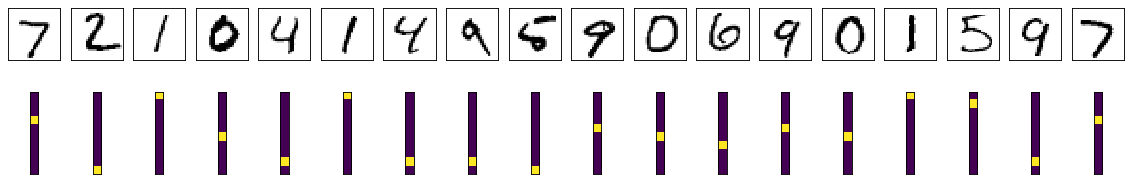

0.9913167953491211
0.17543268203735352
((0.6256466333043987, 0.6249489110107601, 0.6252975775237503, 0.6252976748406572, 0.5480899892297015, 0.6778666666666666), (0.6449697894881341, 0.6440785485140602, 0.6445238609015285, 0.6445240149512944, 0.5680195139358102, 0.696))


In [107]:
t0 = time()
X_test_for_cls_ae = ae.encode(x_test)
print(time()-t0)
#plot66_with_dec(cls_ae, ae, aed, x_test)
t0 = time()
X_train_for_cls_ae = ae.encode(x_train)
print(time()-t0)

plot_activate(18, cls_ae, X_test_for_cls_ae, x_test, (10,1), 10, (18, 3))

t0 = time()
e1 = Evaluate.evaluate_(
    cls_ae.encode(X_train_for_cls_ae, output_argmax=True), y_train)
print(time()-t0)

t0 = time()
e2 = Evaluate.evaluate_(
    cls_ae.encode(X_test_for_cls_ae, output_argmax=True), y_test)
print(time()-t0)
print((e1,e2))

### Duet-CAE algorithm

In [101]:
reload(AutoEncoder)
ae_duet_1 = AutoEncoder.Duet([64, 10], #64, 10
                           input_shape=(144,),
                           loss_confidence_t=0.7, 
                           loss_balance_t=1.0, 
                           loss_side_kernel_t=0.13, #1300,
                           input_dropout=0.3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 144)          0                                            
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 144)          0           input_12[0][0]                   
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 64)           9280        dropout_10[0][0]                 
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 10)           650         dense_43[0][0]                   
__________________________________________________________________________________________________
dense_44 (

In [108]:
encoded = ae.encode(x_train)
#ae_duet_1.fit_(encoded, encoded, epochs=5500,batch_size=30000,verbose=0)
ae.load_weights('../models/noise', 'ae_tt_10')
ae_duet_1.load_weights('../models/noise', 'ae_duet_tt_10')

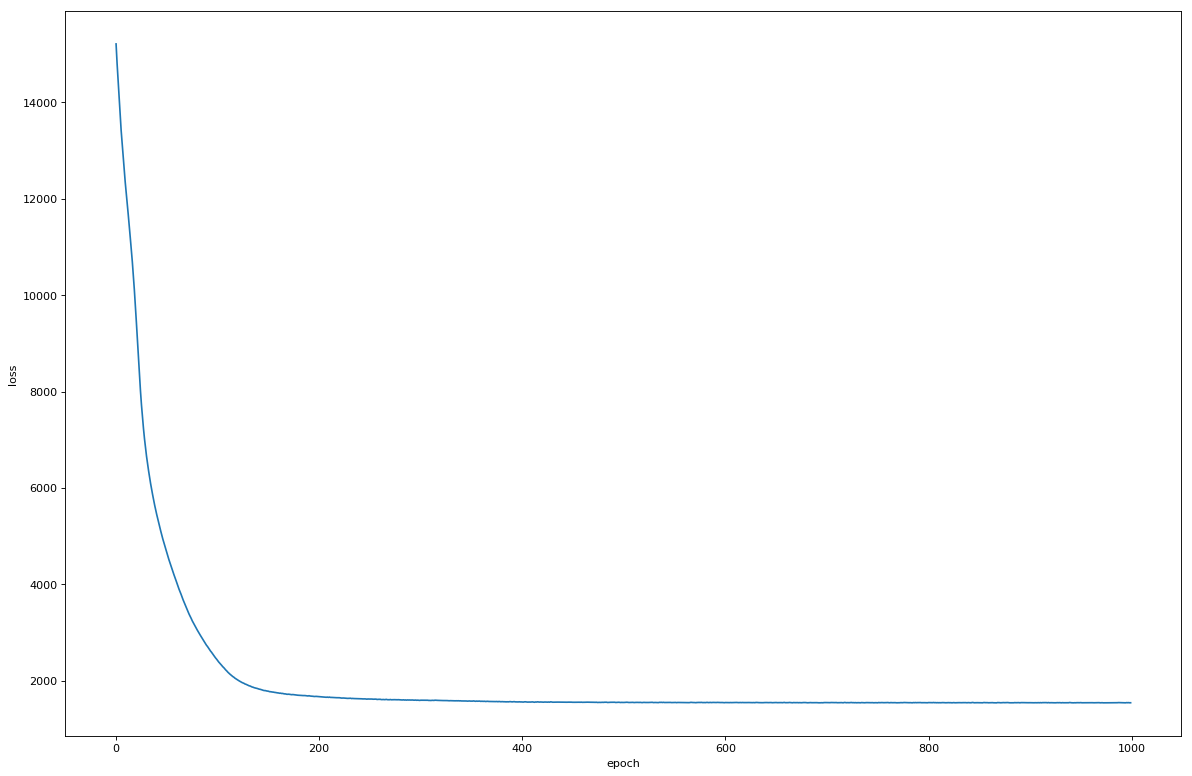

In [637]:
plot_hist(ae_duet_1)

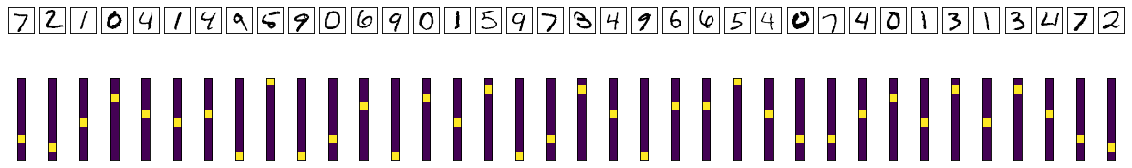

In [103]:
X_test_for_cls_ae = ae.encode(x_test)
#plot66_with_dec(ae_duet_1, ae, aed, x_test)
#plot_activate(36, ae_duet_1, X_test_for_cls_ae, x_test, (10,1), 10, (18, 3))

In [115]:
print(Evaluate.evaluate_(
    ae_duet_1.encode(ae.encode(x_train), output_argmax=True), y_train))
print(Evaluate.evaluate_(
    ae_duet_1.encode(ae.encode(x_test), output_argmax=True), y_test))

(0.7720976792277309, 0.7718727113762479, 0.7719851789122534, 0.7719851871071214, 0.7208077230495071, 0.8323166666666667)
(0.7932858523069074, 0.7928322583243093, 0.7930589904567874, 0.7930590228861971, 0.7492421687024993, 0.8492)


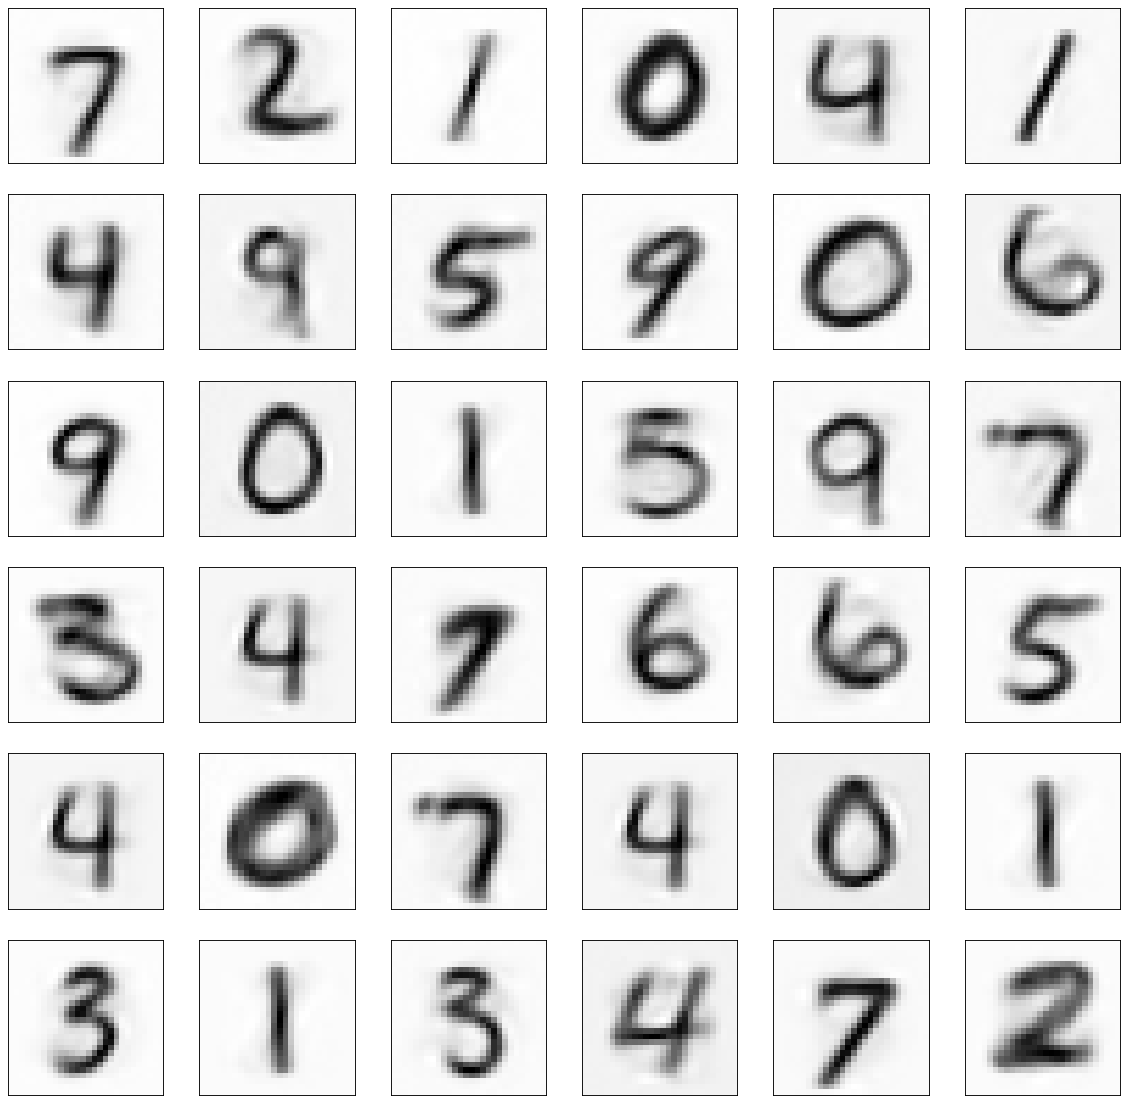

(0.7720976792277309, 0.7718727113762479, 0.7719851789122534, 0.7719851871071214, 0.7208077230495071, 0.8323166666666667)
(0.7932858523069074, 0.7928322583243093, 0.7930589904567874, 0.7930590228861971, 0.7492421687024993, 0.8492)


In [116]:
X_test_for_cls_ae = ae.encode(x_test)
plot66_with_dec(ae_duet_1, ae, aed, x_test)
#plot_activate(36, ae_duet_1, X_test_for_cls_ae, x_test, (10,1), 10, (18, 3))
print(Evaluate.evaluate_(
    ae_duet_1.encode(ae.encode(x_train), output_argmax=True), y_train))
print(Evaluate.evaluate_(
    ae_duet_1.encode(ae.encode(x_test), output_argmax=True), y_test))

## Test on FMNIST

In [87]:
from keras.datasets import fashion_mnist

(x_train_fm, y_train_fm), (x_test_fm, y_test_fm) = fashion_mnist.load_data()

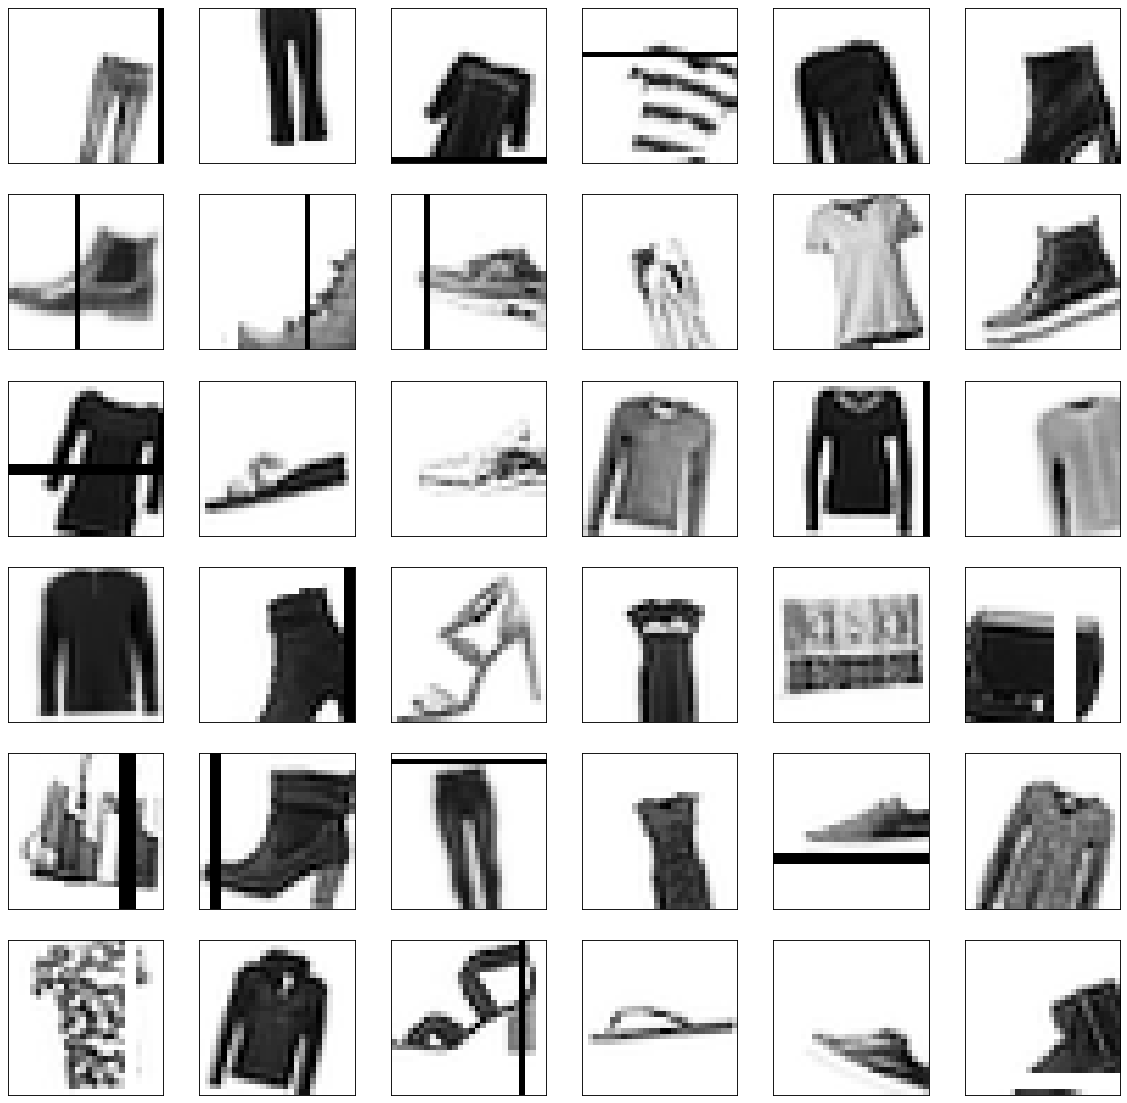

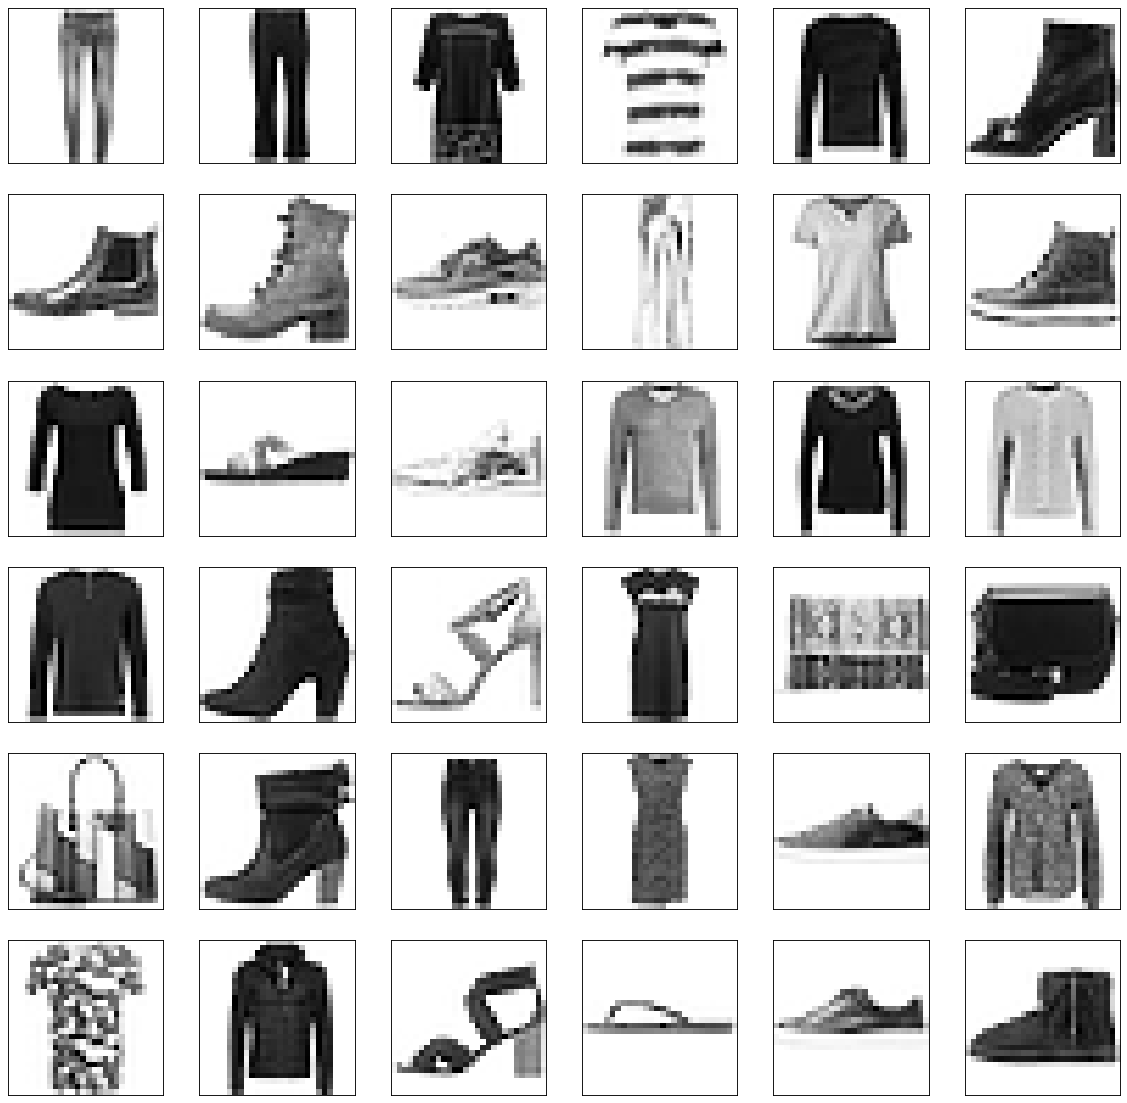

In [149]:
import Preprocessing
reload(Preprocessing)
%matplotlib inline
x_train_fm_noised = Preprocessing.MnistNoisifier().noisify(10, x_train_fm)
plot_raw_66(x_train_fm_noised[0])
plot_raw_66(x_train_fm_noised[1])

In [79]:
import AutoEncoder 
reload(AutoEncoder)
ae_fm = AutoEncoder.Standard([480, 240, 144], input_shape=(28, 28))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 480)               376800    
_________________________________________________________________
dense_27 (Dense)             (None, 240)               115440    
_________________________________________________________________
dense_28 (Dense)             (None, 144)               34704     
_________________________________________________________________
dense_29 (Dense)             (None, 240)               34800     
__________

In [151]:
#ae_fm.fit_(x_train_fm_noised[0], x_train_fm_noised[1], epochs=500, batch_size=5000)
ae_fm.load_weights('../models', 'ae_fm')

Epoch 1/500
600000/600000 [==============================] - 5s 8us/step - loss: 5899.8370
Epoch 2/500
600000/600000 [==============================] - 4s 7us/step - loss: 3818.8239
Epoch 3/500
600000/600000 [==============================] - 4s 7us/step - loss: 3399.9185
Epoch 4/500
600000/600000 [==============================] - 4s 7us/step - loss: 3113.2733
Epoch 5/500
600000/600000 [==============================] - 4s 6us/step - loss: 2878.2936
Epoch 6/500
600000/600000 [==============================] - 4s 7us/step - loss: 2687.1920
Epoch 7/500
600000/600000 [==============================] - 4s 7us/step - loss: 2574.3552
Epoch 8/500
600000/600000 [==============================] - 4s 7us/step - loss: 2480.4848
Epoch 9/500
600000/600000 [==============================] - 4s 7us/step - loss: 2383.5187
Epoch 10/500
600000/600000 [==============================] - 4s 7us/step - loss: 2315.6592
Epoch 11/500
600000/600000 [==============================] - 4s 7us/step - loss: 2252.78

600000/600000 [==============================] - 4s 7us/step - loss: 1620.2306
Epoch 91/500
600000/600000 [==============================] - 4s 7us/step - loss: 1598.2268
Epoch 92/500
600000/600000 [==============================] - 4s 6us/step - loss: 1608.1626
Epoch 93/500
600000/600000 [==============================] - 4s 6us/step - loss: 1607.5620
Epoch 94/500
600000/600000 [==============================] - 4s 7us/step - loss: 1602.4442
Epoch 95/500
600000/600000 [==============================] - 4s 7us/step - loss: 1605.8660
Epoch 96/500
600000/600000 [==============================] - 4s 7us/step - loss: 1601.6803
Epoch 97/500
600000/600000 [==============================] - 4s 7us/step - loss: 1607.9550
Epoch 98/500
600000/600000 [==============================] - 4s 7us/step - loss: 1605.2134
Epoch 99/500
600000/600000 [==============================] - 4s 7us/step - loss: 1597.0651
Epoch 100/500
600000/600000 [==============================] - 4s 7us/step - loss: 1589.7385


600000/600000 [==============================] - 4s 7us/step - loss: 1513.3143
Epoch 267/500
600000/600000 [==============================] - 4s 7us/step - loss: 1512.1992
Epoch 268/500
600000/600000 [==============================] - 4s 7us/step - loss: 1513.2773
Epoch 269/500
600000/600000 [==============================] - 4s 6us/step - loss: 1507.4602
Epoch 270/500
600000/600000 [==============================] - 4s 7us/step - loss: 1502.8124
Epoch 271/500
600000/600000 [==============================] - 4s 7us/step - loss: 1507.6457
Epoch 272/500
600000/600000 [==============================] - 4s 7us/step - loss: 1510.2355
Epoch 273/500
600000/600000 [==============================] - 4s 7us/step - loss: 1511.1361
Epoch 274/500
600000/600000 [==============================] - 4s 7us/step - loss: 1509.7250
Epoch 275/500
600000/600000 [==============================] - 4s 7us/step - loss: 1502.8991
Epoch 276/500
600000/600000 [==============================] - 4s 6us/step - loss: 1

600000/600000 [==============================] - 4s 7us/step - loss: 1497.5205
Epoch 355/500
600000/600000 [==============================] - 4s 7us/step - loss: 1497.1809
Epoch 356/500
600000/600000 [==============================] - 4s 7us/step - loss: 1497.8527
Epoch 357/500
600000/600000 [==============================] - 4s 6us/step - loss: 1497.0552
Epoch 358/500
600000/600000 [==============================] - 4s 7us/step - loss: 1500.0918
Epoch 359/500
600000/600000 [==============================] - 4s 7us/step - loss: 1496.7520
Epoch 360/500
600000/600000 [==============================] - 4s 7us/step - loss: 1499.1701
Epoch 361/500
600000/600000 [==============================] - 4s 6us/step - loss: 1499.2831
Epoch 362/500
600000/600000 [==============================] - 4s 7us/step - loss: 1497.5257
Epoch 363/500
600000/600000 [==============================] - 4s 6us/step - loss: 1499.7536
Epoch 364/500
600000/600000 [==============================] - 4s 7us/step - loss: 1

In [80]:
ae_fm.load_weights('../models', 'ae_fm')

In [81]:
import keras
aed_fm_in = keras.layers.Input(shape=(144,))
aed_fm_h = aed_fm_in
aed_fm_h = ae_fm.autoencoder.layers[-4](aed_fm_h)
aed_fm_h = ae_fm.autoencoder.layers[-3](aed_fm_h)
aed_fm_h = ae_fm.autoencoder.layers[-2](aed_fm_h)
aed_fm_out = ae_fm.autoencoder.layers[-1](aed_fm_h)
aed_fm = keras.Model(aed_fm_in, aed_fm_out)
aed_fm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 144)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 240)               34800     
_________________________________________________________________
dense_30 (Dense)             (None, 480)               115680    
_________________________________________________________________
dense_31 (Dense)             (None, 784)               377104    
_________________________________________________________________
reshape_7 (Reshape)          (None, 28, 28)            0         
Total params: 527,584
Trainable params: 527,584
Non-trainable params: 0
_________________________________________________________________


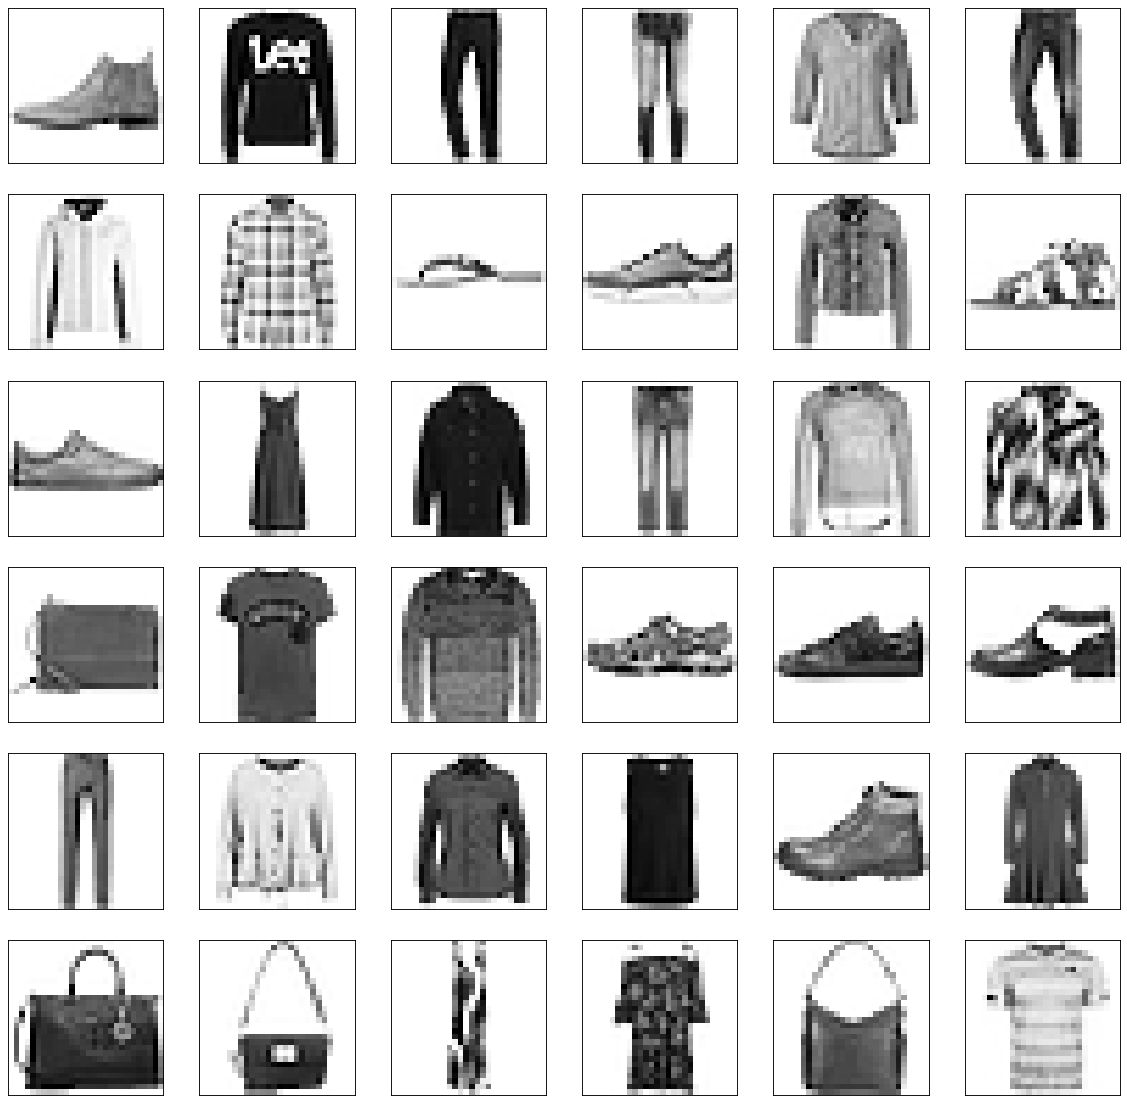

In [157]:
plot_raw_66(x_test_fm)

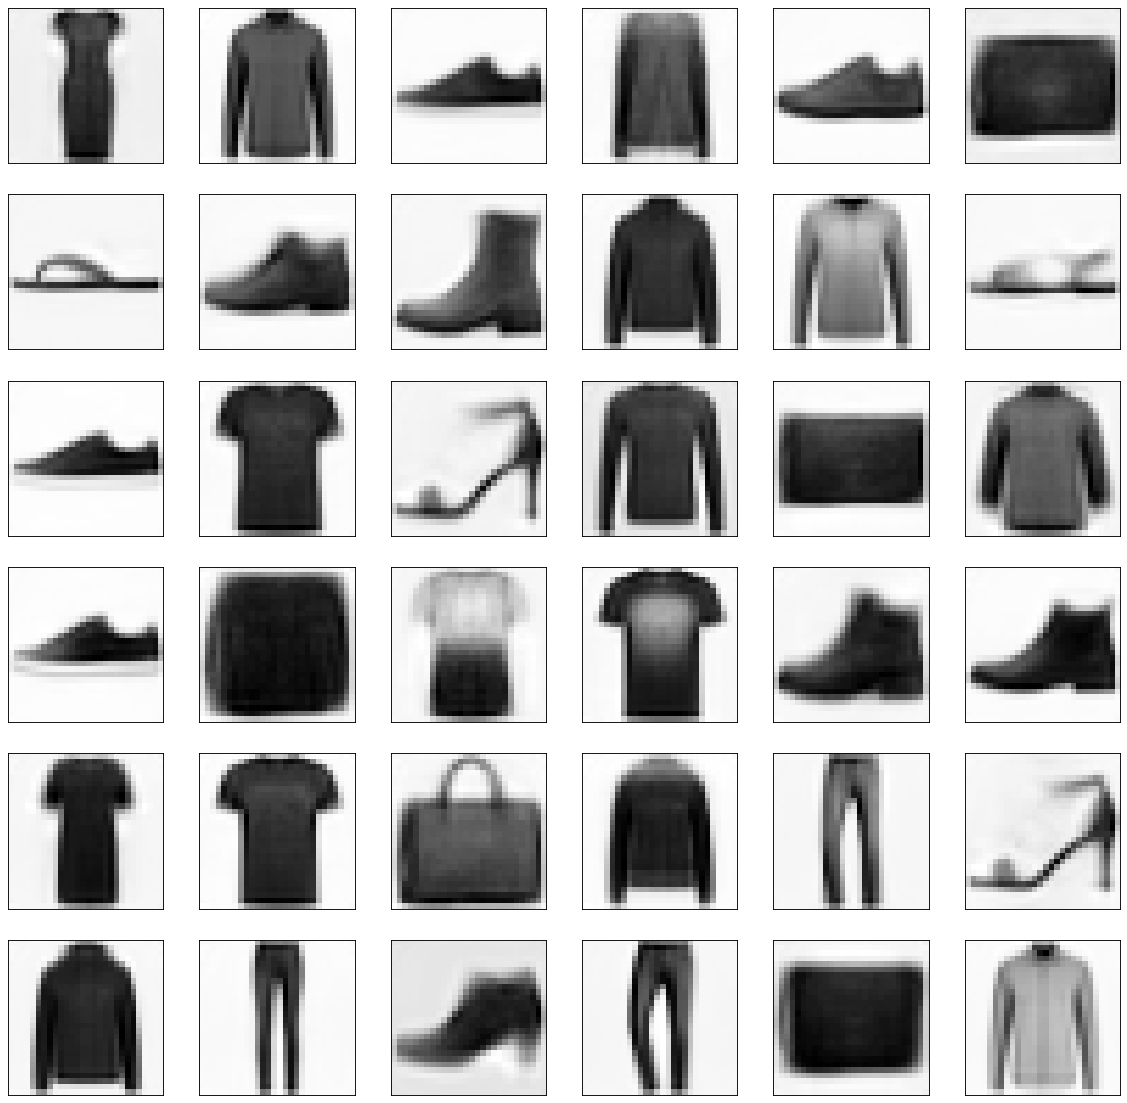

In [172]:
plot66(ae_fm, x_test_fm[100:])
#plot_activate(7, ae_fm, x_test_fm, x_test_fm, (12,12), 144, (14,12), rows=3)

In [82]:
reload(AutoEncoder)
ae_duet_fm = AutoEncoder.Duet([64, 10], #64, 10
                           input_shape=(144,),
                           loss_confidence_t=0.7, 
                           loss_balance_t=1.0, 
                           loss_side_kernel_t=0.16,
                           input_dropout=0.3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 144)          0                                            
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 144)          0           input_9[0][0]                    
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 64)           9280        dropout_8[0][0]                  
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 10)           650         dense_32[0][0]                   
__________________________________________________________________________________________________
dense_33 (

In [88]:
encoded_fm = ae_fm.encode(x_train_fm)
encoded_fm_test = ae_fm.encode(x_test_fm)

In [90]:
#ae_duet_fm.fit_(encoded_fm, encoded_fm, epochs=10000, batch_size=30000,verbose=0)

In [83]:
ae_duet_fm.load_weights('../models', 'ae_duet_fm')

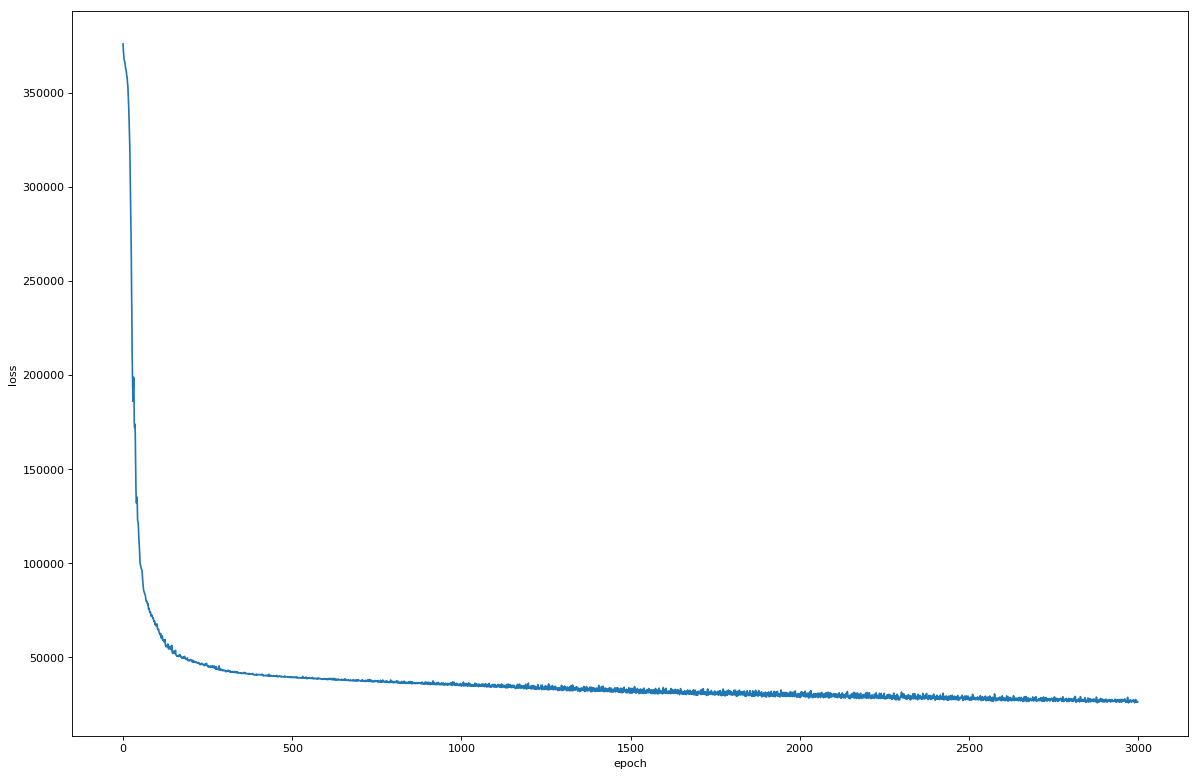

In [170]:
plot_hist(ae_duet_fm)

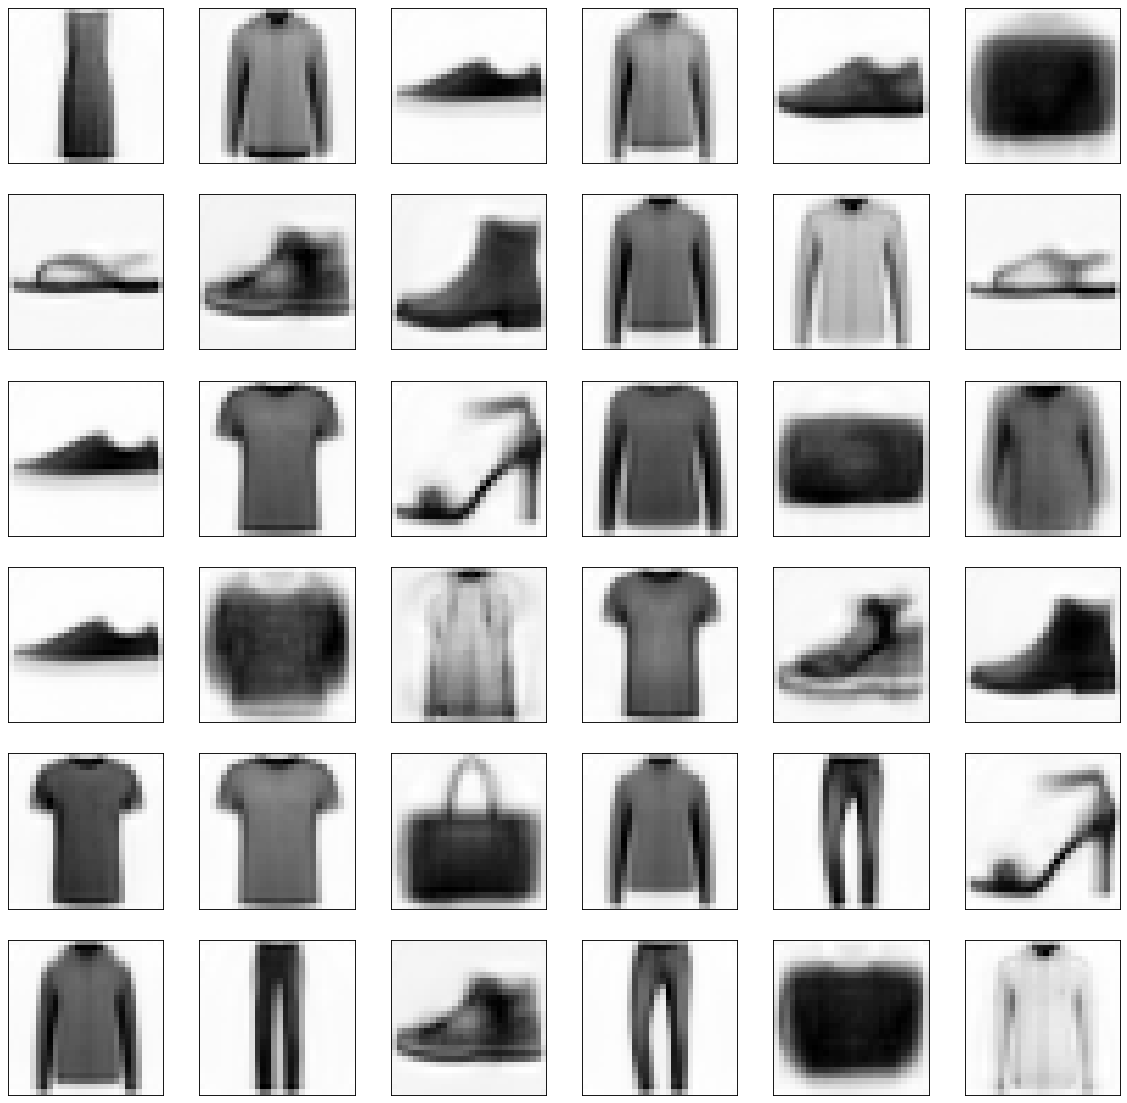

(0.5576512504906057, 0.552138859113219, 0.5548813646192218, 0.5548882096683466, 0.3646131216565855, 0.5211333333333333)
(0.5558551569945647, 0.5500905697436546, 0.5529578398171532, 0.5529653515421095, 0.36000510853553574, 0.5206)


In [110]:
plot66_with_dec(ae_duet_fm, ae_fm, aed_fm, x_test_fm[100:])
#plot_activate(36, ae_duet_1, X_test_for_cls_ae, x_test, (10,1), 10, (18, 3))
print(Evaluate.evaluate_(
    ae_duet_fm.encode(encoded_fm, output_argmax=True), y_train_fm))
print(Evaluate.evaluate_(
    ae_duet_fm.encode(encoded_fm_test, output_argmax=True), y_test_fm))

In [9]:
x_train_fm_1d = x_train_fm.reshape((x_train_fm.shape[0], -1))
x_test_fm_1d = x_test_fm.reshape((x_test_fm.shape[0],-1))

In [179]:
kmfm = cluster.KMeans(n_clusters=10).fit(x_train_fm_1d)
kmeans_score_train = Evaluate.evaluate_(kmfm.predict(x_train_fm_1d), y_train_fm)
kmeans_score_test = Evaluate.evaluate_(kmfm.predict(x_test_fm_1d), y_test_fm)
print(kmeans_score_train, kmeans_score_test)

(0.5237732279170344, 0.5004497549977502, 0.5118459319073282, 0.5119786944643895, 0.3479513428926007, 0.47396666666666665) (0.5245659299666924, 0.5008525282004089, 0.512435035938864, 0.5125721141767435, 0.3491223460180672, 0.4846)


/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [21]:
kmfm2 = cluster.KMeans(n_clusters=10).fit(encoded_fm)
import Evaluate
print(Evaluate.evaluate_(kmfm2.predict(encoded_fm), y_train_fm))
print(Evaluate.evaluate_(kmfm2.predict(encoded_fm_test), y_test_fm))

(0.4809622362946887, 0.45910744506572654, 0.46978079999092043, 0.4699078031681883, 0.29254965021821944, 0.4213166666666667)
(0.47558702617580656, 0.4532310688568817, 0.46414000192479155, 0.4642745052316858, 0.2850168930940243, 0.4218)


/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [25]:
## F-MINIST
aggfm = cluster.AgglomerativeClustering(n_clusters=10).fit(x_test_fm_1d)
print(Evaluate.evaluate_(aggfm.labels_, y_test_fm))
aggfm2 = cluster.AgglomerativeClustering(n_clusters=10).fit(encoded_fm_test)
print(Evaluate.evaluate_(aggfm2.labels_, y_test_fm))

(0.5458382753627481, 0.5073754925365277, 0.5259045641984977, 0.5262556069130885, 0.3477874832212375, 0.5131)
(0.5302507509361167, 0.4819719064039616, 0.5049599778222499, 0.5055353254727234, 0.28479813477993593, 0.4489)


/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [56]:
## MNIST
#x_encoded_test = ae.encode(x_test)
aggfm = cluster.AgglomerativeClustering(n_clusters=4).fit(x_test_rt)
print(Evaluate.evaluate_(aggfm.labels_, y_test_rt))
aggfm2 = cluster.AgglomerativeClustering(n_clusters=4).fit(ert_t)
print(Evaluate.evaluate_(aggfm2.labels_, y_test_rt))

/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(0.44985838709569204, 0.4144144026611744, 0.4314096127516074, 0.4317728508954455, 0.436280435633727, 0.7085)
(0.5931611097340659, 0.5436905930119029, 0.5673494875786361, 0.5678874144607473, 0.6124615681237475, 0.8235)


/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


## REUTERS-10k

In [2]:
from keras.datasets import reuters

Using TensorFlow backend.


Below block is directly copied from [keras-DEC repo](https://github.com/XifengGuo/DEC-keras/blob/master/datasets.py)

In [ ]:


def make_reuters_data(data_dir):
    np.random.seed(1234)
    from sklearn.feature_extraction.text import CountVectorizer
    from os.path import join
    did_to_cat = {}
    cat_list = ['CCAT', 'GCAT', 'MCAT', 'ECAT']
    with open(join(data_dir, 'rcv1-v2.topics.qrels')) as fin:
        for line in fin.readlines():
            line = line.strip().split(' ')
            cat = line[0]
            did = int(line[1])
            if cat in cat_list:
                did_to_cat[did] = did_to_cat.get(did, []) + [cat]
        # did_to_cat = {k: did_to_cat[k] for k in list(did_to_cat.keys()) if len(did_to_cat[k]) > 1}
        for did in list(did_to_cat.keys()):
            if len(did_to_cat[did]) > 1:
                del did_to_cat[did]

    dat_list = ['lyrl2004_tokens_test_pt0.dat',
                'lyrl2004_tokens_test_pt1.dat',
                'lyrl2004_tokens_test_pt2.dat',
                'lyrl2004_tokens_test_pt3.dat',
                'lyrl2004_tokens_train.dat']
    data = []
    target = []
    cat_to_cid = {'CCAT': 0, 'GCAT': 1, 'MCAT': 2, 'ECAT': 3}
    del did
    for dat in dat_list:
        with open(join(data_dir, dat)) as fin:
            for line in fin.readlines():
                if line.startswith('.I'):
                    if 'did' in locals():
                        assert doc != ''
                        if did in did_to_cat:
                            data.append(doc)
                            target.append(cat_to_cid[did_to_cat[did][0]])
                    did = int(line.strip().split(' ')[1])
                    doc = ''
                elif line.startswith('.W'):
                    assert doc == ''
                else:
                    doc += line

    print((len(data), 'and', len(did_to_cat)))
    assert len(data) == len(did_to_cat)

    x = CountVectorizer(dtype=np.float64, max_features=2000).fit_transform(data)
    y = np.asarray(target)

    from sklearn.feature_extraction.text import TfidfTransformer
    x = TfidfTransformer(norm='l2', sublinear_tf=True).fit_transform(x)
    x = x[:10000].astype(np.float32)
    print(x.dtype, x.size)
    y = y[:10000]
    x = np.asarray(x.todense()) * np.sqrt(x.shape[1])
    print('todense succeed')

    p = np.random.permutation(x.shape[0])
    x = x[p]
    y = y[p]
    print('permutation finished')

    assert x.shape[0] == y.shape[0]
    x = x.reshape((x.shape[0], -1))
    np.save(join(data_dir, 'reutersidf10k.npy'), {'data': x, 'label': y})

    

def load_reuters(data_path='./data/reuters'):
    import os
    if not os.path.exists(os.path.join(data_path, 'reutersidf10k.npy')):
        print('making reuters idf features')
        make_reuters_data(data_path)
        print(('reutersidf saved to ' + data_path))
    data = np.load(os.path.join(data_path, 'reutersidf10k.npy')).item()
    # has been shuffled
    x = data['data']
    y = data['label']
    x = x.reshape((x.shape[0], -1)).astype('float64')
    y = y.reshape((y.size,))
    print(('REUTERSIDF10K samples', x.shape))
    return x, y


In [4]:
x_rt, y_rt = load_reuters('../data/reuters')

('REUTERSIDF10K samples', (10000, 2000))


In [6]:
(x_train_rt, x_test_rt) = (x_rt[:8000], x_rt[8000:])
(y_train_rt, y_test_rt) = (y_rt[:8000], y_rt[8000:])

In [5]:
import Preprocessing
#reload(Preprocessing)
#x_train_rt_noised = Preprocessing.TextNoisifier().noisify(5, x_train_rt)

In [7]:
import AutoEncoder 
ae_rt = AutoEncoder.Standard([500, 100], input_shape=(2000,))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1000500   
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_4 (Dense)              (None, 2000)              1002000   
_________________________________________________________________
reshape_1 (Reshape)          (None, 2000)              0         
Total para

In [8]:
ae_rt.load_weights('../models', 'ae_rt')

In [32]:
ae_rt.fit_(x_train_rt, x_train_rt, epochs=5000, batch_size=50000)

Epoch 1/5000
8000/8000 [==============================] - 0s 38us/step - loss: 0.5597
Epoch 2/5000
8000/8000 [==============================] - 0s 40us/step - loss: 0.5598
Epoch 3/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5594
Epoch 4/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5594
Epoch 5/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5598
Epoch 6/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5593
Epoch 7/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5601
Epoch 8/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5597
Epoch 9/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5592
Epoch 10/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5600
Epoch 11/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5590
Epoch 12/5000
8000/8000 [===========================

Epoch 96/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5606
Epoch 97/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5600
Epoch 98/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5608
Epoch 99/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5601
Epoch 100/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5601
Epoch 101/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5602
Epoch 102/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5602
Epoch 103/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5604
Epoch 104/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5601
Epoch 105/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5593
Epoch 106/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5601
Epoch 107/5000
8000/8000 [==========

8000/8000 [==============================] - 0s 42us/step - loss: 0.5594
Epoch 190/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5593
Epoch 191/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5590
Epoch 192/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5597
Epoch 193/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5595
Epoch 194/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5587
Epoch 195/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5593
Epoch 196/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5594
Epoch 197/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5598
Epoch 198/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5590
Epoch 199/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5594
Epoch 200/5000
8000/8000 [=====================

Epoch 283/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5586
Epoch 284/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5588
Epoch 285/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5587
Epoch 286/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5583
Epoch 287/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5590
Epoch 288/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5594
Epoch 289/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5594
Epoch 290/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5588
Epoch 291/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5591
Epoch 292/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5588
Epoch 293/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5597
Epoch 294/5000
8000/8000 [======

8000/8000 [==============================] - 0s 42us/step - loss: 0.5591
Epoch 377/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5584
Epoch 378/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5588
Epoch 379/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5587
Epoch 380/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5585
Epoch 381/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5584
Epoch 382/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5589
Epoch 383/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5591
Epoch 384/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5585
Epoch 385/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5589
Epoch 386/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5588
Epoch 387/5000
8000/8000 [=====================

Epoch 470/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5591
Epoch 471/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5587
Epoch 472/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5593
Epoch 473/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5590
Epoch 474/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5578
Epoch 475/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5582
Epoch 476/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5590
Epoch 477/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5583
Epoch 478/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5581
Epoch 479/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5582
Epoch 480/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5581
Epoch 481/5000
8000/8000 [======

8000/8000 [==============================] - 0s 44us/step - loss: 0.5584
Epoch 564/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5577
Epoch 565/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5577
Epoch 566/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5576
Epoch 567/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5577
Epoch 568/5000
8000/8000 [==============================] - 0s 50us/step - loss: 0.5578
Epoch 569/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5581
Epoch 570/5000
8000/8000 [==============================] - 0s 50us/step - loss: 0.5579
Epoch 571/5000
8000/8000 [==============================] - 0s 57us/step - loss: 0.5574
Epoch 572/5000
8000/8000 [==============================] - 0s 58us/step - loss: 0.5576
Epoch 573/5000
8000/8000 [==============================] - 0s 49us/step - loss: 0.5570
Epoch 574/5000
8000/8000 [=====================

Epoch 657/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5586
Epoch 658/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5590
Epoch 659/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5588
Epoch 660/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5582
Epoch 661/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5583
Epoch 662/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5585
Epoch 663/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5583
Epoch 664/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5582
Epoch 665/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5586
Epoch 666/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5593
Epoch 667/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5578
Epoch 668/5000
8000/8000 [======

8000/8000 [==============================] - 0s 45us/step - loss: 0.5569
Epoch 751/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5569
Epoch 752/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5576
Epoch 753/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5573
Epoch 754/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5568
Epoch 755/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5573
Epoch 756/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5578
Epoch 757/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5569
Epoch 758/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5570
Epoch 759/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5572
Epoch 760/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5568
Epoch 761/5000
8000/8000 [=====================

Epoch 844/5000
8000/8000 [==============================] - 0s 52us/step - loss: 0.5579
Epoch 845/5000
8000/8000 [==============================] - 0s 50us/step - loss: 0.5575
Epoch 846/5000
8000/8000 [==============================] - 0s 49us/step - loss: 0.5577
Epoch 847/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5570
Epoch 848/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5573
Epoch 849/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5572
Epoch 850/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5575
Epoch 851/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5566
Epoch 852/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5571
Epoch 853/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5570
Epoch 854/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5573
Epoch 855/5000
8000/8000 [======

8000/8000 [==============================] - 0s 45us/step - loss: 0.5569
Epoch 938/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5575
Epoch 939/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5568
Epoch 940/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5572
Epoch 941/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5564
Epoch 942/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5572
Epoch 943/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5572
Epoch 944/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5571
Epoch 945/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5567
Epoch 946/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5576
Epoch 947/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5565
Epoch 948/5000
8000/8000 [=====================

Epoch 1030/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5568
Epoch 1031/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5571
Epoch 1032/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5572
Epoch 1033/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5579
Epoch 1034/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5569
Epoch 1035/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5567
Epoch 1036/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5575
Epoch 1037/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5576
Epoch 1038/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5568
Epoch 1039/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5569
Epoch 1040/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5571
Epoch 1041/5000
8000/

8000/8000 [==============================] - 0s 43us/step - loss: 0.5571
Epoch 1123/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5567
Epoch 1124/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5566
Epoch 1125/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5562
Epoch 1126/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5568
Epoch 1127/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5568
Epoch 1128/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5565
Epoch 1129/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5567
Epoch 1130/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5562
Epoch 1131/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5577
Epoch 1132/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5574
Epoch 1133/5000
8000/8000 [==========

Epoch 1215/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5565
Epoch 1216/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5563
Epoch 1217/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5565
Epoch 1218/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5561
Epoch 1219/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5562
Epoch 1220/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5563
Epoch 1221/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5559
Epoch 1222/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5560
Epoch 1223/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5557
Epoch 1224/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5560
Epoch 1225/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5557
Epoch 1226/5000
8000/

8000/8000 [==============================] - 0s 44us/step - loss: 0.5556
Epoch 1308/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5559
Epoch 1309/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5561
Epoch 1310/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5565
Epoch 1311/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5566
Epoch 1312/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5558
Epoch 1313/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5566
Epoch 1314/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5560
Epoch 1315/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5569
Epoch 1316/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5560
Epoch 1317/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5565
Epoch 1318/5000
8000/8000 [==========

Epoch 1400/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5560
Epoch 1401/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5551
Epoch 1402/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5563
Epoch 1403/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5558
Epoch 1404/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5562
Epoch 1405/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5554
Epoch 1406/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5559
Epoch 1407/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5560
Epoch 1408/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5563
Epoch 1409/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5556
Epoch 1410/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5563
Epoch 1411/5000
8000/

8000/8000 [==============================] - 0s 43us/step - loss: 0.5556
Epoch 1493/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5554
Epoch 1494/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5553
Epoch 1495/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5558
Epoch 1496/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5557
Epoch 1497/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5558
Epoch 1498/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5553
Epoch 1499/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5563
Epoch 1500/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5562
Epoch 1501/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5557
Epoch 1502/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5552
Epoch 1503/5000
8000/8000 [==========

Epoch 1585/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5566
Epoch 1586/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5557
Epoch 1587/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5561
Epoch 1588/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5551
Epoch 1589/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5554
Epoch 1590/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5554
Epoch 1591/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5556
Epoch 1592/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5552
Epoch 1593/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5561
Epoch 1594/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5555
Epoch 1595/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5555
Epoch 1596/5000
8000/

8000/8000 [==============================] - 0s 43us/step - loss: 0.5553
Epoch 1678/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5548
Epoch 1679/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5555
Epoch 1680/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5555
Epoch 1681/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5550
Epoch 1682/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5555
Epoch 1683/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5547
Epoch 1684/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5557
Epoch 1685/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5557
Epoch 1686/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5552
Epoch 1687/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5556
Epoch 1688/5000
8000/8000 [==========

Epoch 1770/5000
8000/8000 [==============================] - 0s 53us/step - loss: 0.5554
Epoch 1771/5000
8000/8000 [==============================] - 0s 51us/step - loss: 0.5549
Epoch 1772/5000
8000/8000 [==============================] - 0s 50us/step - loss: 0.5558
Epoch 1773/5000
8000/8000 [==============================] - 0s 49us/step - loss: 0.5552
Epoch 1774/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5551
Epoch 1775/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5555
Epoch 1776/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5558
Epoch 1777/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5558
Epoch 1778/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5555
Epoch 1779/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5550
Epoch 1780/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5553
Epoch 1781/5000
8000/

8000/8000 [==============================] - 0s 46us/step - loss: 0.5552
Epoch 1863/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5554
Epoch 1864/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5557
Epoch 1865/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5556
Epoch 1866/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5553
Epoch 1867/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5558
Epoch 1868/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5551
Epoch 1869/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5546
Epoch 1870/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5553
Epoch 1871/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5550
Epoch 1872/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5556
Epoch 1873/5000
8000/8000 [==========

Epoch 1955/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5549
Epoch 1956/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5550
Epoch 1957/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5544
Epoch 1958/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5557
Epoch 1959/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5551
Epoch 1960/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5555
Epoch 1961/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5549
Epoch 1962/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5552
Epoch 1963/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5546
Epoch 1964/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5545
Epoch 1965/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5548
Epoch 1966/5000
8000/

8000/8000 [==============================] - 0s 42us/step - loss: 0.5552
Epoch 2048/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5546
Epoch 2049/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5549
Epoch 2050/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5547
Epoch 2051/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5544
Epoch 2052/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5540
Epoch 2053/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5546
Epoch 2054/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5541
Epoch 2055/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5545
Epoch 2056/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5548
Epoch 2057/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5546
Epoch 2058/5000
8000/8000 [==========

Epoch 2140/5000
8000/8000 [==============================] - 0s 55us/step - loss: 0.5550
Epoch 2141/5000
8000/8000 [==============================] - 0s 51us/step - loss: 0.5555
Epoch 2142/5000
8000/8000 [==============================] - 0s 50us/step - loss: 0.5546
Epoch 2143/5000
8000/8000 [==============================] - 0s 53us/step - loss: 0.5542
Epoch 2144/5000
8000/8000 [==============================] - 0s 58us/step - loss: 0.5543
Epoch 2145/5000
8000/8000 [==============================] - 0s 56us/step - loss: 0.5543
Epoch 2146/5000
8000/8000 [==============================] - 0s 52us/step - loss: 0.5548
Epoch 2147/5000
8000/8000 [==============================] - 0s 50us/step - loss: 0.5545
Epoch 2148/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5548
Epoch 2149/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5540
Epoch 2150/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5545
Epoch 2151/5000
8000/

8000/8000 [==============================] - 0s 43us/step - loss: 0.5541
Epoch 2233/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5549
Epoch 2234/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5543
Epoch 2235/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5554
Epoch 2236/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5545
Epoch 2237/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5547
Epoch 2238/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5538
Epoch 2239/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5548
Epoch 2240/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5541
Epoch 2241/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5544
Epoch 2242/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5545
Epoch 2243/5000
8000/8000 [==========

Epoch 2325/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5538
Epoch 2326/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5536
Epoch 2327/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5540
Epoch 2328/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5541
Epoch 2329/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5546
Epoch 2330/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5534
Epoch 2331/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5540
Epoch 2332/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5543
Epoch 2333/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5548
Epoch 2334/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5536
Epoch 2335/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5539
Epoch 2336/5000
8000/

8000/8000 [==============================] - 0s 43us/step - loss: 0.5534
Epoch 2418/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5541
Epoch 2419/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5538
Epoch 2420/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5547
Epoch 2421/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5541
Epoch 2422/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5543
Epoch 2423/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5536
Epoch 2424/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5537
Epoch 2425/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5538
Epoch 2426/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5537
Epoch 2427/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5543
Epoch 2428/5000
8000/8000 [==========

Epoch 2510/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5545
Epoch 2511/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5540
Epoch 2512/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5540
Epoch 2513/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5537
Epoch 2514/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5536
Epoch 2515/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5538
Epoch 2516/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5536
Epoch 2517/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5533
Epoch 2518/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5536
Epoch 2519/5000
8000/8000 [==============================] - 0s 50us/step - loss: 0.5536
Epoch 2520/5000
8000/8000 [==============================] - 0s 49us/step - loss: 0.5533
Epoch 2521/5000
8000/

8000/8000 [==============================] - 0s 43us/step - loss: 0.5536
Epoch 2603/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5535
Epoch 2604/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5525
Epoch 2605/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5538
Epoch 2606/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5533
Epoch 2607/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5533
Epoch 2608/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5536
Epoch 2609/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5541
Epoch 2610/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5539
Epoch 2611/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5537
Epoch 2612/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5539
Epoch 2613/5000
8000/8000 [==========

Epoch 2695/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5532
Epoch 2696/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5527
Epoch 2697/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5528
Epoch 2698/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5534
Epoch 2699/5000
8000/8000 [==============================] - 0s 51us/step - loss: 0.5532
Epoch 2700/5000
8000/8000 [==============================] - 0s 53us/step - loss: 0.5537
Epoch 2701/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5537
Epoch 2702/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5533
Epoch 2703/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5530
Epoch 2704/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5530
Epoch 2705/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5533
Epoch 2706/5000
8000/

8000/8000 [==============================] - 0s 44us/step - loss: 0.5523
Epoch 2788/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5524
Epoch 2789/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5535
Epoch 2790/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5529
Epoch 2791/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5530
Epoch 2792/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5529
Epoch 2793/5000
8000/8000 [==============================] - 0s 61us/step - loss: 0.5524
Epoch 2794/5000
8000/8000 [==============================] - 0s 58us/step - loss: 0.5526
Epoch 2795/5000
8000/8000 [==============================] - 0s 53us/step - loss: 0.5529
Epoch 2796/5000
8000/8000 [==============================] - 0s 51us/step - loss: 0.5530
Epoch 2797/5000
8000/8000 [==============================] - 0s 51us/step - loss: 0.5532
Epoch 2798/5000
8000/8000 [==========

Epoch 2880/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5528
Epoch 2881/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5524
Epoch 2882/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5528
Epoch 2883/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5523
Epoch 2884/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5530
Epoch 2885/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5528
Epoch 2886/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5520
Epoch 2887/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5527
Epoch 2888/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5525
Epoch 2889/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5530
Epoch 2890/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5524
Epoch 2891/5000
8000/

8000/8000 [==============================] - 0s 43us/step - loss: 0.5530
Epoch 2973/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5531
Epoch 2974/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5522
Epoch 2975/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5528
Epoch 2976/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5530
Epoch 2977/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5523
Epoch 2978/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5526
Epoch 2979/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5526
Epoch 2980/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5531
Epoch 2981/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5531
Epoch 2982/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5526
Epoch 2983/5000
8000/8000 [==========

Epoch 3065/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5522
Epoch 3066/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5522
Epoch 3067/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5522
Epoch 3068/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5528
Epoch 3069/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5521
Epoch 3070/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5522
Epoch 3071/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5512
Epoch 3072/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5522
Epoch 3073/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5523
Epoch 3074/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5522
Epoch 3075/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5524
Epoch 3076/5000
8000/

8000/8000 [==============================] - 0s 42us/step - loss: 0.5526
Epoch 3158/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5519
Epoch 3159/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5517
Epoch 3160/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5515
Epoch 3161/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5520
Epoch 3162/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5521
Epoch 3163/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5521
Epoch 3164/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5521
Epoch 3165/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5517
Epoch 3166/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5523
Epoch 3167/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5522
Epoch 3168/5000
8000/8000 [==========

Epoch 3250/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5523
Epoch 3251/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5520
Epoch 3252/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5516
Epoch 3253/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5521
Epoch 3254/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5521
Epoch 3255/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5511
Epoch 3256/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5514
Epoch 3257/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5511
Epoch 3258/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5521
Epoch 3259/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5523
Epoch 3260/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5519
Epoch 3261/5000
8000/

8000/8000 [==============================] - 0s 43us/step - loss: 0.5514
Epoch 3343/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5511
Epoch 3344/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5521
Epoch 3345/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5519
Epoch 3346/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5516
Epoch 3347/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5519
Epoch 3348/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5515
Epoch 3349/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5516
Epoch 3350/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5524
Epoch 3351/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5519
Epoch 3352/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5517
Epoch 3353/5000
8000/8000 [==========

Epoch 3435/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5522
Epoch 3436/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5512
Epoch 3437/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5524
Epoch 3438/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5518
Epoch 3439/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5520
Epoch 3440/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5518
Epoch 3441/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5517
Epoch 3442/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5518
Epoch 3443/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5522
Epoch 3444/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5521
Epoch 3445/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5520
Epoch 3446/5000
8000/

8000/8000 [==============================] - 0s 43us/step - loss: 0.5505
Epoch 3528/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5508
Epoch 3529/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5513
Epoch 3530/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5513
Epoch 3531/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5512
Epoch 3532/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5508
Epoch 3533/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5510
Epoch 3534/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5517
Epoch 3535/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5512
Epoch 3536/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5507
Epoch 3537/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5507
Epoch 3538/5000
8000/8000 [==========

Epoch 3620/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5510
Epoch 3621/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5513
Epoch 3622/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5515
Epoch 3623/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5514
Epoch 3624/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5507
Epoch 3625/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5518
Epoch 3626/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5508
Epoch 3627/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5516
Epoch 3628/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5511
Epoch 3629/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5515
Epoch 3630/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5508
Epoch 3631/5000
8000/

8000/8000 [==============================] - 0s 43us/step - loss: 0.5512
Epoch 3713/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5509
Epoch 3714/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5517
Epoch 3715/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5511
Epoch 3716/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5514
Epoch 3717/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5512
Epoch 3718/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5509
Epoch 3719/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5513
Epoch 3720/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5504
Epoch 3721/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5515
Epoch 3722/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5508
Epoch 3723/5000
8000/8000 [==========

Epoch 3805/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5508
Epoch 3806/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5503
Epoch 3807/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5505
Epoch 3808/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5505
Epoch 3809/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5506
Epoch 3810/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5503
Epoch 3811/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5496
Epoch 3812/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5506
Epoch 3813/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5500
Epoch 3814/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5506
Epoch 3815/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5509
Epoch 3816/5000
8000/

8000/8000 [==============================] - 0s 45us/step - loss: 0.5509
Epoch 3898/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5504
Epoch 3899/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5507
Epoch 3900/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5506
Epoch 3901/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5513
Epoch 3902/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5512
Epoch 3903/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5508
Epoch 3904/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5514
Epoch 3905/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5509
Epoch 3906/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5503
Epoch 3907/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5508
Epoch 3908/5000
8000/8000 [==========

Epoch 3990/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5511
Epoch 3991/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5505
Epoch 3992/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5503
Epoch 3993/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5507
Epoch 3994/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5507
Epoch 3995/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5512
Epoch 3996/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5502
Epoch 3997/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5505
Epoch 3998/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5499
Epoch 3999/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5503
Epoch 4000/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5504
Epoch 4001/5000
8000/

8000/8000 [==============================] - 0s 43us/step - loss: 0.5507
Epoch 4083/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5500
Epoch 4084/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5499
Epoch 4085/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5501
Epoch 4086/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5493
Epoch 4087/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5501
Epoch 4088/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5502
Epoch 4089/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5507
Epoch 4090/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5500
Epoch 4091/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5499
Epoch 4092/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5499
Epoch 4093/5000
8000/8000 [==========

Epoch 4175/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5496
Epoch 4176/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5493
Epoch 4177/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5504
Epoch 4178/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5498
Epoch 4179/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5505
Epoch 4180/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5489
Epoch 4181/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5496
Epoch 4182/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5498
Epoch 4183/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5498
Epoch 4184/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5500
Epoch 4185/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5499
Epoch 4186/5000
8000/

8000/8000 [==============================] - 0s 46us/step - loss: 0.5499
Epoch 4268/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5496
Epoch 4269/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5501
Epoch 4270/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5509
Epoch 4271/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5499
Epoch 4272/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5498
Epoch 4273/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5499
Epoch 4274/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5504
Epoch 4275/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5496
Epoch 4276/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5499
Epoch 4277/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5497
Epoch 4278/5000
8000/8000 [==========

Epoch 4360/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5500
Epoch 4361/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5499
Epoch 4362/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5500
Epoch 4363/5000
8000/8000 [==============================] - 0s 41us/step - loss: 0.5501
Epoch 4364/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5498
Epoch 4365/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5508
Epoch 4366/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5509
Epoch 4367/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5507
Epoch 4368/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5502
Epoch 4369/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5493
Epoch 4370/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5501
Epoch 4371/5000
8000/

8000/8000 [==============================] - 0s 47us/step - loss: 0.5501
Epoch 4453/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5490
Epoch 4454/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5489
Epoch 4455/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5487
Epoch 4456/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5496
Epoch 4457/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5492
Epoch 4458/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5495
Epoch 4459/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5493
Epoch 4460/5000
8000/8000 [==============================] - 0s 49us/step - loss: 0.5499
Epoch 4461/5000
8000/8000 [==============================] - 0s 51us/step - loss: 0.5494
Epoch 4462/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5495
Epoch 4463/5000
8000/8000 [==========

Epoch 4545/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5494
Epoch 4546/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5487
Epoch 4547/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5495
Epoch 4548/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5491
Epoch 4549/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5491
Epoch 4550/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5492
Epoch 4551/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5500
Epoch 4552/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5494
Epoch 4553/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5491
Epoch 4554/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5495
Epoch 4555/5000
8000/8000 [==============================] - 0s 50us/step - loss: 0.5495
Epoch 4556/5000
8000/

8000/8000 [==============================] - 0s 43us/step - loss: 0.5488
Epoch 4638/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5490
Epoch 4639/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5488
Epoch 4640/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5488
Epoch 4641/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5494
Epoch 4642/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5490
Epoch 4643/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5497
Epoch 4644/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5495
Epoch 4645/5000
8000/8000 [==============================] - 0s 47us/step - loss: 0.5495
Epoch 4646/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5496
Epoch 4647/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5500
Epoch 4648/5000
8000/8000 [==========

Epoch 4730/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5483
Epoch 4731/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5489
Epoch 4732/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5489
Epoch 4733/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5488
Epoch 4734/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5482
Epoch 4735/5000
8000/8000 [==============================] - 0s 42us/step - loss: 0.5489
Epoch 4736/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5488
Epoch 4737/5000
8000/8000 [==============================] - 0s 46us/step - loss: 0.5487
Epoch 4738/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5487
Epoch 4739/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5495
Epoch 4740/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5490
Epoch 4741/5000
8000/

8000/8000 [==============================] - 0s 48us/step - loss: 0.5503
Epoch 4823/5000
8000/8000 [==============================] - 0s 49us/step - loss: 0.5486
Epoch 4824/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5491
Epoch 4825/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5492
Epoch 4826/5000
8000/8000 [==============================] - 0s 49us/step - loss: 0.5487
Epoch 4827/5000
8000/8000 [==============================] - 0s 48us/step - loss: 0.5487
Epoch 4828/5000
8000/8000 [==============================] - 0s 49us/step - loss: 0.5490
Epoch 4829/5000
8000/8000 [==============================] - 0s 54us/step - loss: 0.5487
Epoch 4830/5000
8000/8000 [==============================] - 0s 57us/step - loss: 0.5496
Epoch 4831/5000
8000/8000 [==============================] - 0s 56us/step - loss: 0.5493
Epoch 4832/5000
8000/8000 [==============================] - 0s 59us/step - loss: 0.5486
Epoch 4833/5000
8000/8000 [==========

Epoch 4915/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5477
Epoch 4916/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5489
Epoch 4917/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5486
Epoch 4918/5000
8000/8000 [==============================] - 0s 45us/step - loss: 0.5479
Epoch 4919/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5480
Epoch 4920/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5489
Epoch 4921/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5484
Epoch 4922/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5482
Epoch 4923/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5479
Epoch 4924/5000
8000/8000 [==============================] - 0s 44us/step - loss: 0.5483
Epoch 4925/5000
8000/8000 [==============================] - 0s 43us/step - loss: 0.5486
Epoch 4926/5000
8000/

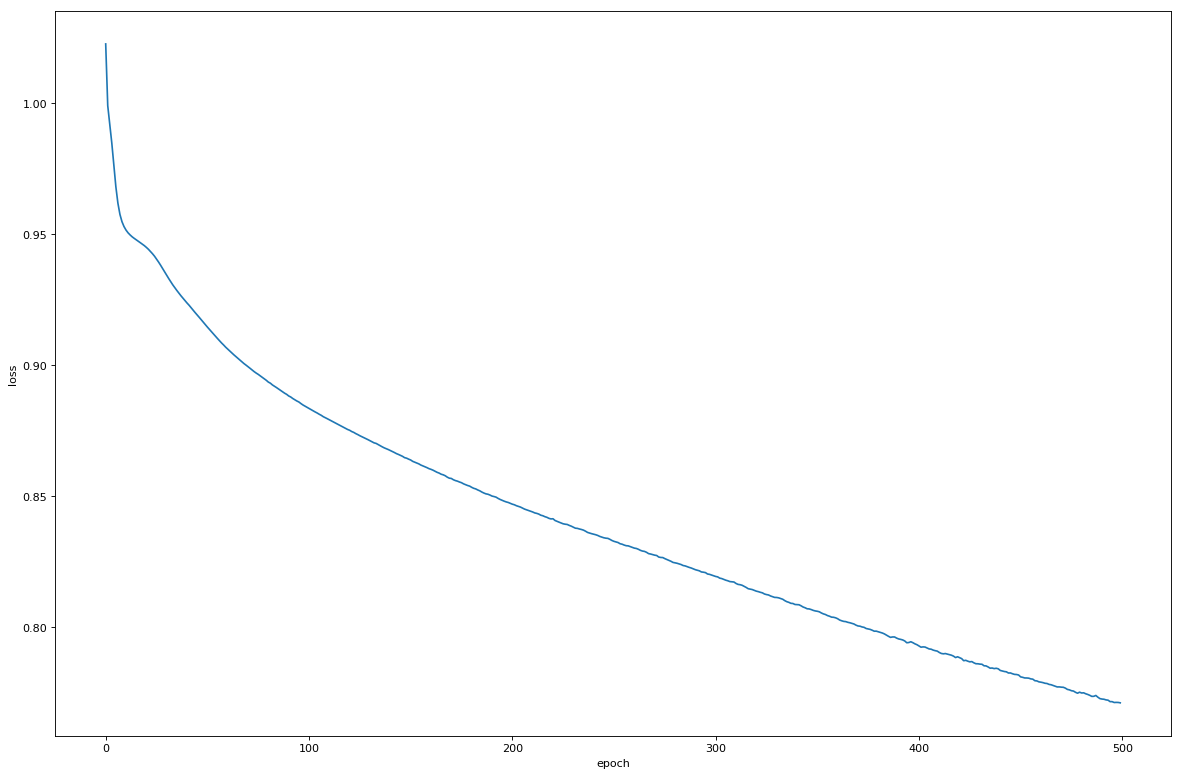

In [16]:
plot_hist(ae_rt)

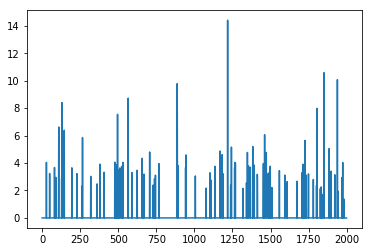

In [17]:
plt.plot(x_train_rt[10])

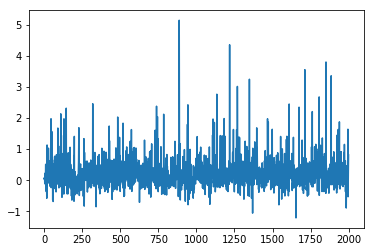

In [20]:
plt.plot(ae_rt.predict_raw(x_train_rt[10:])[0])

In [39]:
ae_rt.save_weights('../models', 'ae_rt')

In [49]:
kmfm = cluster.KMeans(n_clusters=4).fit(x_train_rt)
import Evaluate
kmeans_score_train = Evaluate.evaluate_(kmfm.predict(x_train_rt), y_train_rt)
kmeans_score_test = Evaluate.evaluate_(kmfm.predict(x_test_rt), y_test_rt)
print(kmeans_score_train, kmeans_score_test)

(0.3695622942432801, 0.3341156893949736, 0.35094621001801407, 0.35139231738255405, 0.23591313226397245, 0.54075) (0.3790969259252149, 0.33446285569323636, 0.3553839319303812, 0.3560812272915755, 0.2497147935427248, 0.548)


/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/clyce/anaconda3/envs/marlo/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [35]:
ert = ae_rt.encode(x_train_rt)
ert_t  = ae_rt.encode(x_test_rt)

In [ ]:
aggfm = cluster.AgglomerativeClustering(n_clusters=10).fit(x_test_fm_1d)
print(Evaluate.evaluate_(aggfm.labels_, y_test_fm))
aggfm2 = cluster.AgglomerativeClustering(n_clusters=10).fit(encoded_fm_test)
print(Evaluate.evaluate_(aggfm2.labels_, y_test_fm))

In [45]:
duet_rt =  AutoEncoder.Duet([32, 4], #64, 10
                           input_shape=(100,),
                           loss_confidence_t=0.7, 
                           loss_balance_t=1.0, 
                           loss_side_kernel_t=0.16,
                           input_dropout=0.3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 100)          0           input_4[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 32)           3232        dropout_4[0][0]                  
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 10)           330         dense_17[0][0]                   
__________________________________________________________________________________________________
dense_18 (

In [52]:
duet_rt.fit_(ert, ert, epochs=5000, batch_size=30000,verbose=0)
#duet_rt.save_weights('../models', 'duet_rt')